#Avance 3. Baseline

###Tecnológico de Monterrey

###Maestría en Inteligencia Artificial Aplicada

**Proyecto**: Predicción de la demanda de aguacate mexicano a Estados Unidos

**Organización:** APEJAL

Prof. Gerardo Camacho González, PhD


**Equipo 28:**

Nayelhi Yajaira de Anda de la Torre - A01795504

Iris Monserrat Urbina Casas - A01795999

José Luis Plata Osorio - A01796090


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---



#**Análisis exploratorio de datos**

## Estructura de los datos

### Descripción de las variables del dataset:

- **Amount** *(float / numérica continua)*: Importaciones totales de aguacate mexicano a Estados Unidos de América, medidas en *thousand pounds*. Datos obtenidos del Departamento de Agricultura de Estados Unidos (USDA).
- **tipo_cambio_usd_mxn** *(float / numérica continua)*: Tipo de cambio peso mexicano – dólar estadounidense, obtenido del Banco de México.
- **Year** *(int / numérica discreta)*: Año de importación.
- **MonthNumber** *(int / numérica discreta)*: Mes de importación (1–12).
- **evento_exportacion** *(int / dummy binaria 0–1)*: Variable dummy que considera eventos relevantes en Estados Unidos, como el Super Bowl y el 5 de mayo.
- **inspeccion_intensificada** *(int / dummy binaria 0–1)*: Variable dummy que indica periodos con inspecciones intensificadas a las exportaciones.
- **cierre_exportacion** *(int / dummy binaria 0–1)*: Variable dummy que indica periodos con cierres temporales de exportación.


In [51]:
# Importación de Librerías:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge



##Procesamiento de los datos

##**Archivo `fruit-trade-data.csv` (importaciones USA)**
El archivo mostrado a continuación, es el dataset proveniente del Departamento de Agricultura de Estados Unidos (USDA).
A continuación presentamos el pre-procesamiento realizado para obtener los datos de Importación de aguacate mexicano a Estados Unidos de América:

## 0. Carga de archivo

In [52]:
PATH_TRADE = "fruit-trade-data.csv"
df_trade = pd.read_csv(PATH_TRADE)
df_trade


,Trade,GeographicDesc,Year,MonthNumber,MarketYear,Group,Subgroup,MarketSegment,CommodityName,CommodityDetail,UnitType,UnitDesc,Amount
0,Import,Argentina,2025,10,2024/25,Fruit and tree nuts,Citrus,Prepared or preserved,Oranges,Peel,Value,Thousand dollars,243.52500
1,Import,Argentina,2025,10,2024/25,Fruit and tree nuts,Citrus,Prepared or preserved,Oranges,Peel,Volume,Thousand pounds,216.93487
2,Import,Australia,2025,10,2024/25,Fruit and tree nuts,Citrus,Fresh,Oranges,Temples,Value,Thousand dollars,12.60000
3,Import,Australia,2025,10,2024/25,Fruit and tree nuts,Citrus,Fresh,Oranges,Temples,Volume,Thousand pounds,44.44519
4,Import,Australia,2025,10,2024/25,Fruit and tree nuts,Citrus,Fresh,Oranges,Unspecified,Value,Thousand dollars,2816.94800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
842407,Export,World,2017,1,2017,Fruit and tree nuts,Tree nuts,Fresh,"Nuts, other",Other,Volume,Thousand pounds,850.45081
842408,Export,World,2017,1,2017,Fruit and tree nuts,Tree nuts,Fresh,"Nuts, other",Other,Unit value,Dollars per pound,2.19140
842409,Export,World,2017,1,2017,Fruit and tree nuts,Tree nuts,Prepared or preserved,"Nuts, other",Other,Value,Thousand dollars,13808.77600
842410,Export,World,2017,1,2017,Fruit and tree nuts,Tree nuts,Prepared or preserved,"Nuts, other",Other,Volume,Thousand pounds,6209.32402


 1. Se aplican filtros para obtener los datos del volumen de importaciones de aguacates mexicanos



In [53]:
def norm(s):
    return s.astype(str).str.strip().str.lower()

# Se crea fecha mensual a partir de Year + MonthNumber (para ordenar)
df_trade["fecha"] = pd.to_datetime(
    df_trade["Year"].astype(int).astype(str) + "-" +
    df_trade["MonthNumber"].astype(int).astype(str) + "-01",
    errors="coerce"
)

# Se aplican filtros
df_trade_f = df_trade[
    (norm(df_trade["Trade"]) == "import") &
    (norm(df_trade["GeographicDesc"]) == "mexico") &
    (norm(df_trade["CommodityName"]) == "avocados") &
    (norm(df_trade["CommodityDetail"]) == "hass avocados and hass-like avocados") &
    (norm(df_trade["MarketSegment"]) == "fresh") &
    (norm(df_trade["UnitType"]) == "volume")
].copy()

print("Shape (df_trade filtrado):", df_trade_f.shape)
display(df_trade_f[["Year","MonthNumber","Trade","GeographicDesc","CommodityName","CommodityDetail","MarketSegment","UnitType","UnitDesc","Amount","fecha"]].head(10))


Shape (df_trade filtrado): (106, 14)


,Year,MonthNumber,Trade,GeographicDesc,CommodityName,CommodityDetail,MarketSegment,UnitType,UnitDesc,Amount,fecha
1382,2025,10,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,250302.35186,2025-10-01
9779,2025,9,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,207860.15867,2025-09-01
17760,2025,8,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,185185.00873,2025-08-01
26824,2025,7,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,157471.70306,2025-07-01
35401,2025,6,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,140346.36208,2025-06-01
43752,2025,5,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,153833.52899,2025-05-01
52279,2025,4,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,161459.68460,2025-04-01
60614,2025,3,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,219103.38350,2025-03-01
68896,2025,2,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,170956.37433,2025-02-01
77160,2025,1,Import,Mexico,Avocados,Hass avocados and Hass-like avocados,Fresh,Volume,Thousand pounds,259771.49483,2025-01-01


2. Se convierte `Amount` de Thousand pounds a toneladas métricas para:

* Entender magnitudes reales (evitar interpretar miles de libras sin contexto).

* Comparar con otras fuentes (SIAVI, FAOSTAT, Banxico) que reportan en toneladas.

* Visualizar series en una escala comprensible.

* Validar órdenes de magnitud y detectar outliers.


In [54]:
# Se convierte Amount a numérico
df_trade_f["Amount"] = pd.to_numeric(df_trade_f["Amount"], errors="coerce")

# Conversión: thousand pounds -> toneladas métricas
# 1 thousand pounds = 0.453592 toneladas
CONV_TON = 0.453592
df_trade_f["importaciones_ton"] = df_trade_f["Amount"] * CONV_TON

# Se valida unicidad Year-MonthNumber
dup_months = df_trade_f.duplicated(subset=["Year","MonthNumber"]).sum()
print("Duplicados por (Year, MonthNumber):", dup_months)

# Se define serie mensual
df_trade_f_monthly = (
    df_trade_f[["Year","MonthNumber","fecha","importaciones_ton"]]
    .dropna()
    .sort_values(["Year","MonthNumber"])
    .reset_index(drop=True)
)

print("Serie mensual importaciones:", df_trade_f_monthly.shape)
display(df_trade_f_monthly.head(12))


Duplicados por (Year, MonthNumber): 0
Serie mensual importaciones: (106, 4)


,Year,MonthNumber,fecha,importaciones_ton
0,2017,1,2017-01-01,90275.525358
1,2017,2,2017-02-01,66692.899595
2,2017,3,2017-03-01,73229.683266
3,2017,4,2017-04-01,69023.139695
4,2017,5,2017-05-01,56802.240664
5,2017,6,2017-06-01,51053.703352
6,2017,7,2017-07-01,46745.537869
7,2017,8,2017-08-01,48425.876495
8,2017,9,2017-09-01,55755.854519
9,2017,10,2017-10-01,65462.255602


## 1. Análisis descriptivo (univariante)

1. Se utiliza el método `info()` del dataframe, para obtener el resumen de los tipos de datos.

In [55]:
df_trade_f_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Year               106 non-null    int64         
 1   MonthNumber        106 non-null    int64         
 2   fecha              106 non-null    datetime64[ns]
 3   importaciones_ton  106 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.4 KB


Número de columnas datetime: 1

Número de columnas numéricas: 3

Número de columnas cualitativas: 0

 2. Se determina el porcentaje de valores faltantes por columna.

In [56]:
df_trade_f_monthly.isna().mean() * 100

,0
Year,0.0
MonthNumber,0.0
fecha,0.0
importaciones_ton,0.0


###Análisis de variables numéricas

3. Se obtienen las siguientes estadísticas descriptivas para todas las variables numéricas:
*   Tendencia central (media, mediana)
*   Dispersión o variabilidad (min, max, desviación estándar, cuartiles)

In [57]:
# Tendencia central y Dispersión
df_trade_f_monthly.describe().T

,count,mean,min,25%,50%,75%,max,std
Year,106.0,2020.924528,2017.0,2019.0,2021.0,2023.0,2025.0,2.558638
MonthNumber,106.0,6.40566,1.0,3.25,6.0,9.0,12.0,3.430336
fecha,106,2021-05-16 21:44:09.056603648,2017-01-01 00:00:00,2019-03-08 18:00:00,2021-05-16 12:00:00,2023-07-24 06:00:00,2025-10-01 00:00:00,NaN
importaciones_ton,106.0,82505.470858,34103.622182,69232.132276,82770.250483,94911.210328,131092.233064,20556.689229


El conjunto de datos cuenta con 106 observaciones mensuales entre 2017 y 2025, lo que proporciona una base temporal adecuada para el análisis de series de tiempo. La variable de importaciones presenta una media y mediana similares, indicando una distribución relativamente simétrica, aunque con una variabilidad significativa asociada a factores estacionales y eventos específicos. Estas características justifican el uso de modelos que capturen estacionalidad y choques temporales en la demanda.

4. Se utilizan histogramas para determinar la distribución de los valores representados en cada variable.

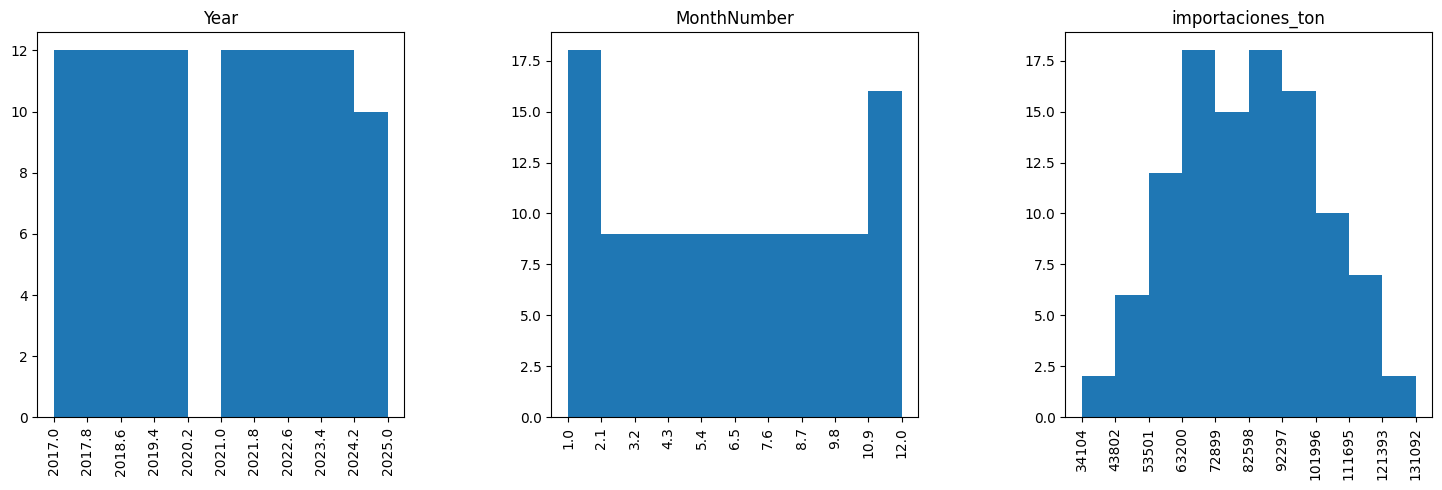

In [58]:
# Se hace una lista de variables numéricas
num_cols = df_trade_f_monthly.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(1,3, figsize=(18,5))
plt.subplots_adjust(wspace=0.4)

axes = axes.ravel()
for col, ax in zip(df_trade_f_monthly[num_cols], axes):
  n, bins, edges = ax.hist(df_trade_f_monthly[col])
  ax.set_xticks(bins)
  ax.tick_params(axis='x',rotation=90)
  ax.set(title=f'{col}', xlabel=None)

Los histogramas indican que los datos cubren de manera equilibrada el periodo de 2017 a 2025 y que se cuenta con información para todos los meses del año, lo que facilita el análisis de la estacionalidad sin distorsiones. Asimismo, las importaciones mensuales muestran una variación relevante, pero sin presencia de valores extremos, lo que respalda que la serie es adecuada para modelar la demanda internacional.

5. Se emplean boxplots para mostrar la distribución de los datos a través de sus cuartiles.

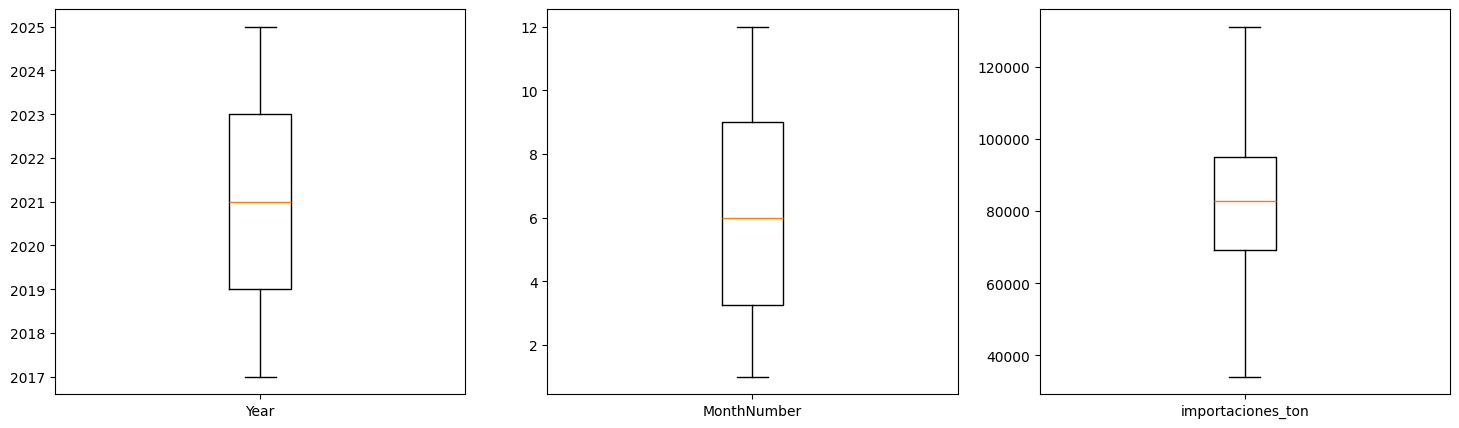

In [59]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
axes = axes.ravel()
for col, ax in zip(df_trade_f_monthly[num_cols], axes):
  ax.boxplot(df_trade_f_monthly[col], tick_labels=[f'{col}'])


Los boxplots indican que las variables de tiempo se distribuyen de manera homogénea durante el periodo analizado, mientras que las importaciones mensuales presentan una dispersión relevante sin la presencia de valores atípicos extremos. Esto sugiere que los datos representan de forma adecuada el comportamiento del mercado y resultan apropiados para el análisis y modelado de la demanda internacional.

### Gráficas de Importaciones USA y Estacionalidad (promedio por mes)


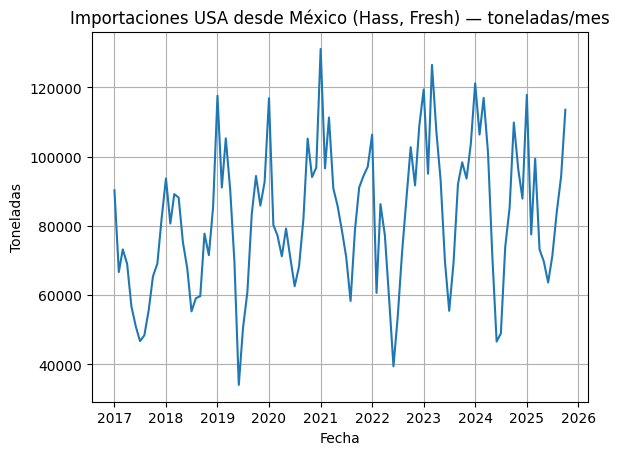

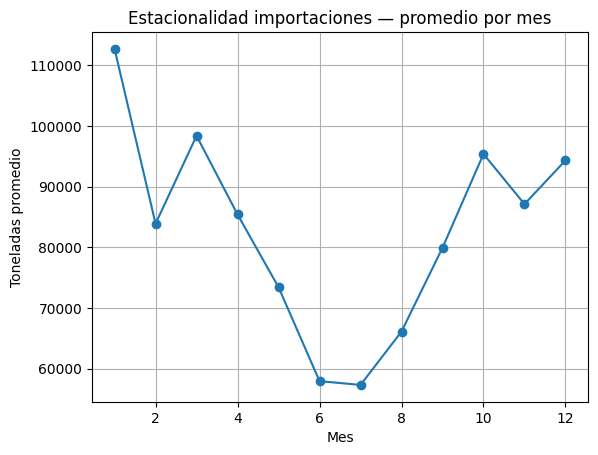

In [60]:
# Importaciones USA
plt.plot(df_trade_f_monthly["fecha"], df_trade_f_monthly["importaciones_ton"])
plt.title("Importaciones USA desde México (Hass, Fresh) — toneladas/mes")
plt.xlabel("Fecha")
plt.ylabel("Toneladas")
plt.grid(True)
plt.show()

# Estacionalidad importaciones
imports_seasonal = df_trade_f_monthly.groupby("MonthNumber")["importaciones_ton"].mean().reset_index()
plt.plot(imports_seasonal["MonthNumber"], imports_seasonal["importaciones_ton"], marker="o")
plt.title("Estacionalidad importaciones — promedio por mes")
plt.xlabel("Mes")
plt.ylabel("Toneladas promedio")
plt.grid(True)
plt.show()


## Análisis de variables de texto
No aplica

---

##**Archivo `BM Tipos de cambio diarios.csv`**


## 0. Carga de archivo


In [61]:
PATH_FX = "BM Tipos de cambio diarios.csv"
df_fx = pd.read_csv(PATH_FX)
df_fx

,Fecha,SF60653,SF43718,SF43787,SF43784,SF43788,SF43786,SF43785,SF43717,SF63528,SF343410
0,02/01/91,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E,2.9447,N/E
1,03/01/91,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E,2.9459,N/E
2,04/01/91,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E,2.9463,N/E
3,07/01/91,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E,2.9467,N/E
4,08/01/91,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E,2.9471,N/E
...,...,...,...,...,...,...,...,...,...,...,...
12701,16/01/26,17.8167,17.6867,17.7235,17.728,N/E,N/E,17.735,17.639,17.6867,17.6465
12702,17/01/26,17.6897,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E
12703,18/01/26,17.6897,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E
12704,19/01/26,17.6897,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E,N/E


 1. Se aplican filtros para obtener los datos del Tipo de Cambio correspondientes al mismo período de los datos de las importaciones

In [62]:
# Se convierte Fecha en formato dd/mm/aa
df_fx["Fecha"] = pd.to_datetime(df_fx["Fecha"], format="%d/%m/%y", errors="coerce")

# Se filtra rango de fechas
df_fx = df_fx[(df_fx["Fecha"] >= "2017-01-01") & (df_fx["Fecha"] <= "2025-10-31")].copy()

# Se conservan columnas Fecha y Tipo de cambio diario (SF60653)
df_fx = df_fx[["Fecha","SF60653"]].rename(columns={"SF60653":"tipo_cambio"})
df_fx["tipo_cambio"] = pd.to_numeric(df_fx["tipo_cambio"], errors="coerce")
df_fx = df_fx.dropna().reset_index(drop=True)

# Se crea Year y MonthNumber
df_fx["Year"] = df_fx["Fecha"].dt.year
df_fx["MonthNumber"] = df_fx["Fecha"].dt.month

# Se crea Tipo de cambio promedio mensual
df_fx_monthly = (
    df_fx.groupby(["Year","MonthNumber"], as_index=False)["tipo_cambio"]
    .mean()
    .sort_values(["Year","MonthNumber"])
    .reset_index(drop=True)
)
# Se crea fecha mensual de referencia
df_fx_monthly["fecha"] = pd.to_datetime(
    df_fx_monthly["Year"].astype(str) + "-" + df_fx_monthly["MonthNumber"].astype(str) + "-01",
    errors="coerce"
)

display(df_fx_monthly.head(12))
print("Rango:", df_fx_monthly["fecha"].min(), "→", df_fx_monthly["fecha"].max())


,Year,MonthNumber,tipo_cambio,fecha
0,2017,1,21.395497,2017-01-01
1,2017,2,20.352457,2017-02-01
2,2017,3,19.416481,2017-03-01
3,2017,4,18.781217,2017-04-01
4,2017,5,18.799710,2017-05-01
5,2017,6,18.208147,2017-06-01
6,2017,7,17.854590,2017-07-01
7,2017,8,17.806497,2017-08-01
8,2017,9,17.805537,2017-09-01
9,2017,10,18.713616,2017-10-01


Rango: 2017-01-01 00:00:00 → 2025-10-01 00:00:00


## 1. Análisis descriptivo (univariante)

1. Se utiliza el método `info()` del dataframe, para obtener el resumen de los tipos de datos.

In [63]:
df_fx_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Year         106 non-null    int32         
 1   MonthNumber  106 non-null    int32         
 2   tipo_cambio  106 non-null    float64       
 3   fecha        106 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 2.6 KB


Número de columnas datetime: 1

Número de columnas numéricas: 3

Número de columnas cualitativas: 0

 2. Se determina el porcentaje de valores faltantes por columna.

In [64]:
df_fx_monthly.isna().mean() * 100

,0
Year,0.0
MonthNumber,0.0
tipo_cambio,0.0
fecha,0.0


###Análisis de variables numéricas

3. Se obtienen las siguientes estadísticas descriptivas para todas las variables numéricas:
*   Tendencia central (media, mediana)
*   Dispersión o variabilidad (min, max, desviación estándar, cuartiles)

In [65]:
# Tendencia central y Dispersión
df_fx_monthly.describe().T

,count,mean,min,25%,50%,75%,max,std
Year,106.0,2020.924528,2017.0,2019.0,2021.0,2023.0,2025.0,2.558638
MonthNumber,106.0,6.40566,1.0,3.25,6.0,9.0,12.0,3.430336
tipo_cambio,106.0,19.424452,16.782557,18.662206,19.338172,20.221078,24.239883,1.393885
fecha,106,2021-05-16 21:44:09.056603648,2017-01-01 00:00:00,2019-03-08 18:00:00,2021-05-16 12:00:00,2023-07-24 06:00:00,2025-10-01 00:00:00,NaN


Las estadísticas descriptivas muestran que el conjunto de datos abarca de manera continua el periodo de 2017 a 2025 y una distribución mensual uniforme. El tipo de cambio presenta una variabilidad moderada y consistente con el contexto macroeconómico del periodo considerado. En general, no se identifican comportamientos atípicos en los datos y resultan adecuados para el análisis exploratorio y el posterior modelado de la demanda internacional.

4. Se utilizan histogramas para determinar la distribución de los valores representados en cada variable.

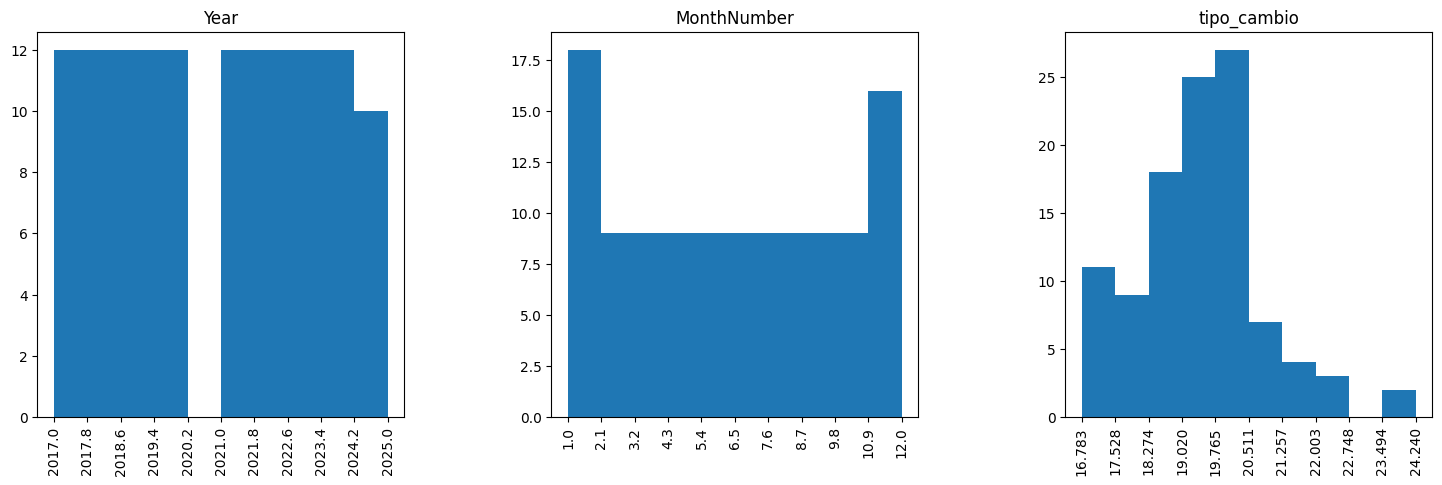

In [66]:
# Se hace una lista de variables numéricas
num_cols = df_fx_monthly.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(1,3, figsize=(18,5))
plt.subplots_adjust(wspace=0.4)

axes = axes.ravel()
for col, ax in zip(df_fx_monthly[num_cols], axes):
  n, bins, edges = ax.hist(df_fx_monthly[col])
  ax.set_xticks(bins)
  ax.tick_params(axis='x',rotation=90)
  ax.set(title=f'{col}', xlabel=None)

Los histogramas muestran una cobertura temporal equilibrada y una distribución mensual completa, mientras que el tipo de cambio presenta una variación moderada consistente con el contexto macroeconómico. En conjunto, los datos no exhiben comportamientos atípicos y resultan adecuados para el análisis exploratorio y el modelado de la demanda.

5. Se emplean boxplots para mostrar la distribución de los datos a través de sus cuartiles.

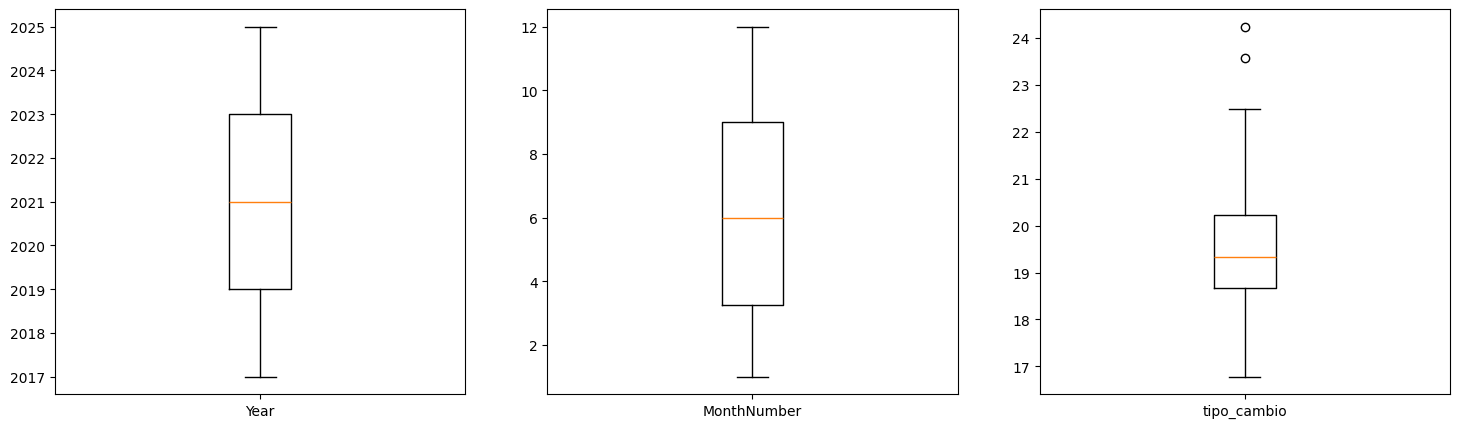

In [67]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
axes = axes.ravel()
for col, ax in zip(df_fx_monthly[num_cols], axes):
  ax.boxplot(df_fx_monthly[col], tick_labels=[f'{col}'])

Los boxplots muestran una distribución equilibrada de las variables temporales y una variabilidad moderada en el tipo de cambio. Aunque se identifican algunos valores atípicos en esta última variable, estos corresponden a episodios macroeconómicos reales y no a errores en los datos, por lo que se considera apropiado conservarlos para el análisis y modelado de la demanda.

###Gráfica de Tipo de cambio mensual (promedio)

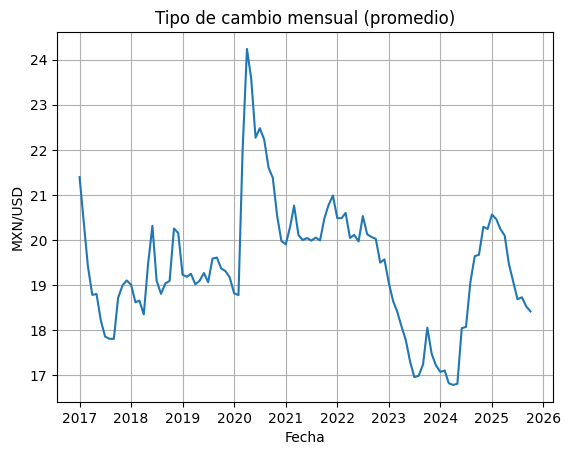

In [68]:
plt.plot(df_fx_monthly["fecha"], df_fx_monthly["tipo_cambio"])
plt.title("Tipo de cambio mensual (promedio)")
plt.xlabel("Fecha")
plt.ylabel("MXN/USD")
plt.grid(True)
plt.show()


##Integración de archivos (merge mensual) y análisis conjunto


In [69]:
# Se hace Merge mensual por Year y MonthNumber
df_trade_merged = df_trade_f_monthly.merge(
    df_fx_monthly[["Year","MonthNumber","tipo_cambio"]],
    on=["Year","MonthNumber"],
    how="left",
    validate="one_to_one"
)

print("Shape:", df_trade_merged.shape)
print("NAs tipo_cambio_mensual:", df_trade_merged["tipo_cambio"].isna().sum())
display(df_trade_merged.head(12))


Shape: (106, 5)
NAs tipo_cambio_mensual: 0


,Year,MonthNumber,fecha,importaciones_ton,tipo_cambio
0,2017,1,2017-01-01,90275.525358,21.395497
1,2017,2,2017-02-01,66692.899595,20.352457
2,2017,3,2017-03-01,73229.683266,19.416481
3,2017,4,2017-04-01,69023.139695,18.781217
4,2017,5,2017-05-01,56802.240664,18.799710
5,2017,6,2017-06-01,51053.703352,18.208147
6,2017,7,2017-07-01,46745.537869,17.854590
7,2017,8,2017-08-01,48425.876495,17.806497
8,2017,9,2017-09-01,55755.854519,17.805537
9,2017,10,2017-10-01,65462.255602,18.713616


1. Mapa de calor con los valores de correlación de todas las variables del dataframe.

<Axes: >

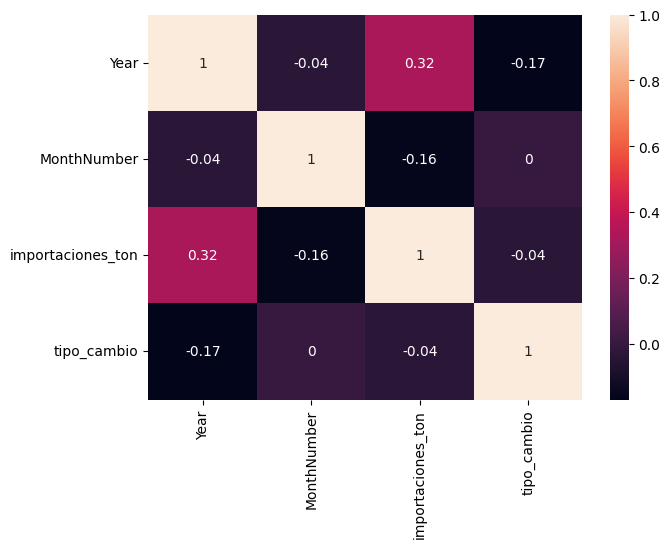

In [70]:
plt.figure(figsize = (7, 5))
sns.heatmap(round(df_trade_merged.corr(numeric_only=True),2), annot = True)

**Interpretación**

**1. Year - importaciones_ton (0.32)**

* Correlación positiva moderada.

* Indica que, conforme avanzan los años, las importaciones tienden a incrementarse.

**Implicación:**
  Existe una tendencia de crecimiento de largo plazo en la demanda. Esto refuerza:

* la necesidad de normalizar la serie (definir un índice de demanda),

* evitar usar Year directamente como variable explicativa.

**2. MonthNumber - importaciones_ton (-0.16)**

* Correlación negativa débil.

* El mes, tratado de forma lineal, no explica correctamente las variaciones en importaciones.

**Implicación:**
La estacionalidad no es lineal, por lo que es correcto:

* no usar MonthNumber directamente,

* usar transformaciones cíclicas (mes_sin, mes_cos).

**3. tipo_cambio - importaciones_ton (-0.04)**

* Correlación prácticamente nula.

* No existe una relación lineal directa entre tipo de cambio e importaciones mensuales.

**Implicación clave:**

El tipo de cambio:

* actúa como incentivo económico indirecto,

* su efecto no se refleja de forma inmediata ni lineal en el volumen importado,

* es correcto incluirlo como variable exógena, no esperar alta correlación simple.

**4. Year - tipo_cambio (-0.17)**

* Relación negativa débil.

* Sugiere que algunos periodos recientes tuvieron tipo de cambio más alto, pero sin patrón fuerte.

**Implicación:**
* No hay colinealidad problemática entre Year y tipo_cambio.

**5. MonthNumber - tipo_cambio (0.00)**

* Correlación nula.

**Implicación:**

El tipo de cambio no tiene estacionalidad mensual, lo cual es coherente con su naturaleza macroeconómica.

El mapa de calor muestra una correlación positiva moderada entre el tiempo y las importaciones, lo que sugiere una tendencia creciente de largo plazo. El mes del año no presenta una relación lineal fuerte con las importaciones, confirmando que la estacionalidad debe modelarse mediante transformaciones cíclicas. Asimismo, el tipo de cambio no exhibe una correlación lineal directa con el volumen importado, lo que es consistente con su papel como incentivo económico indirecto. En conjunto, no se identifican problemas de multicolinealidad en las variables analizadas.

2. Gráficas

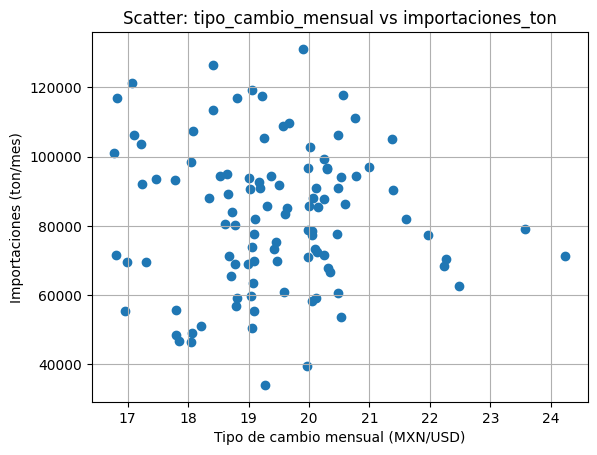

In [71]:
# Scatter
plt.scatter(df_trade_merged["tipo_cambio"], df_trade_merged["importaciones_ton"])
plt.title("Scatter: tipo_cambio_mensual vs importaciones_ton")
plt.xlabel("Tipo de cambio mensual (MXN/USD)")
plt.ylabel("Importaciones (ton/mes)")
plt.grid(True)
plt.show()

El diagrama de dispersión muestra una relación débil y no lineal entre el tipo de cambio mensual y el volumen de importaciones. La alta dispersión de los puntos indica que el tipo de cambio actúa como un factor contextual que influye de manera indirecta en la demanda, mientras que otros factores como la estacionalidad y los eventos específicos tienen un papel más relevante. Estos resultados respaldan su inclusión como variable exógena en el modelo de demanda.

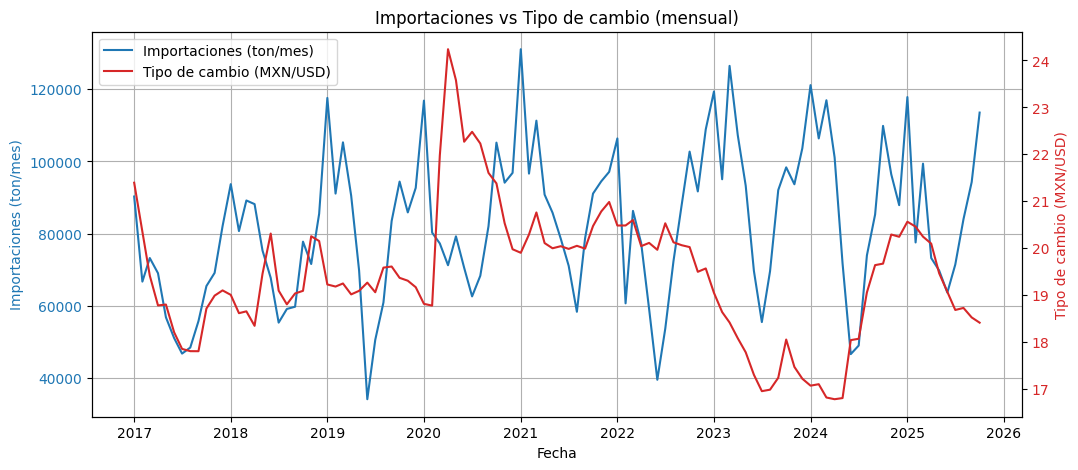

In [72]:
# Series alineadas (dos ejes)
fig, ax1 = plt.subplots(figsize=(12,5))

# Línea 1: Importaciones (eje izquierdo)
ax1.plot(
    df_trade_merged["fecha"],
    df_trade_merged["importaciones_ton"],
    color="tab:blue",
    label="Importaciones (ton/mes)"
)
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Importaciones (ton/mes)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True)

# Línea 2: Tipo de cambio (eje derecho)
ax2 = ax1.twinx()
ax2.plot(
    df_trade_merged["fecha"],
    df_trade_merged["tipo_cambio"],
    color="tab:red",
    label="Tipo de cambio (MXN/USD)"
)
ax2.set_ylabel("Tipo de cambio (MXN/USD)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Título y leyenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title("Importaciones vs Tipo de cambio (mensual)")
plt.show()


La comparación visual de las series muestra que las importaciones mensuales presentan una estacionalidad marcada y variaciones abruptas, mientras que el tipo de cambio evoluciona de manera más gradual. No se observa una sincronización directa entre ambas series, lo que sugiere que el tipo de cambio actúa como un factor contextual cuyo efecto sobre la demanda es indirecto y depende de la interacción con otros elementos, como la estacionalidad y los eventos específicos.

##Variables dummy asociadas a eventos específicos

En esta etapa se crearán variables dummy asociadas a eventos específicos que podrían afectar el comportamiento de la demanda de aguacate mexicano hacia Estados Unidos. Dichas variables se definirán a partir de información externa y calendarios de eventos, y se incorporarán como variables explicativas en el análisis.


In [73]:
# =========================================
# 1. Crear eje temporal mensual
# =========================================
years = range(2017, 2026)
months = range(1, 13)

calendar = pd.DataFrame(
    [(y, m) for y in years for m in months],
    columns=["Year", "MonthNumber"]
)

# =========================================
# 2. evento_exportacion
# Enero y Febrero (Super Bowl) + Mayo (5 de mayo)
# =========================================
calendar["evento_exportacion"] = np.where(
    calendar["MonthNumber"].isin([1, 2, 5]),
    1,
    0
)

# =========================================
# 3. inspeccion_intensificada
# Fechas exactas
# =========================================
inspeccion_periodos = [
    (2017, 5),
    (2017, 6),
    (2022, 3),
    (2022, 4),
    (2024, 6),
    (2024, 7),
    (2025, 4),
    (2025, 5)
]

calendar["inspeccion_intensificada"] = np.where(
    calendar[["Year", "MonthNumber"]].apply(tuple, axis=1).isin(inspeccion_periodos),
    1,
    0
)

# =========================================
# 4. cierre_exportacion
# Fechas exactas
# =========================================
cierre_periodos = [
    (2022, 2),
    (2024, 6)
]

calendar["cierre_exportacion"] = np.where(
    calendar[["Year", "MonthNumber"]].apply(tuple, axis=1).isin(cierre_periodos),
    1,
    0
)

# Vista rápida del calendario
display(calendar.head(12))


,Year,MonthNumber,evento_exportacion,inspeccion_intensificada,cierre_exportacion
0,2017,1,1,0,0
1,2017,2,1,0,0
2,2017,3,0,0,0
3,2017,4,0,0,0
4,2017,5,1,1,0
5,2017,6,0,1,0
6,2017,7,0,0,0
7,2017,8,0,0,0
8,2017,9,0,0,0
9,2017,10,0,0,0


In [74]:
# 1) Confirmar tamaño esperado: (2017–2025) = 9 años * 12 meses = 108 filas
print(calendar.shape)

(108, 5)


##Construir Data Frame final

In [75]:
df_final = df_trade_merged.merge(
    calendar,
    on=["Year", "MonthNumber"],
    how="left",
    validate="one_to_one"
)

In [76]:
print(
    df_final[
        ["evento_exportacion", "inspeccion_intensificada", "cierre_exportacion"]
    ].isna().sum()
)

display(df_final.head(20))

evento_exportacion          0
inspeccion_intensificada    0
cierre_exportacion          0
dtype: int64


,Year,MonthNumber,fecha,importaciones_ton,tipo_cambio,evento_exportacion,inspeccion_intensificada,cierre_exportacion
0,2017,1,2017-01-01,90275.525358,21.395497,1,0,0
1,2017,2,2017-02-01,66692.899595,20.352457,1,0,0
2,2017,3,2017-03-01,73229.683266,19.416481,0,0,0
3,2017,4,2017-04-01,69023.139695,18.781217,0,0,0
4,2017,5,2017-05-01,56802.240664,18.799710,1,1,0
5,2017,6,2017-06-01,51053.703352,18.208147,0,1,0
6,2017,7,2017-07-01,46745.537869,17.854590,0,0,0
7,2017,8,2017-08-01,48425.876495,17.806497,0,0,0
8,2017,9,2017-09-01,55755.854519,17.805537,0,0,0
9,2017,10,2017-10-01,65462.255602,18.713616,0,0,0


In [77]:
# Renombrar columnas
df_final = df_final.rename(columns={
    "importaciones_ton": "Amount",
    "tipo_cambio": "tipo_cambio_usd_mxn"
})
df_final.head(10)



,Year,MonthNumber,fecha,Amount,tipo_cambio_usd_mxn,evento_exportacion,inspeccion_intensificada,cierre_exportacion
0,2017,1,2017-01-01,90275.525358,21.395497,1,0,0
1,2017,2,2017-02-01,66692.899595,20.352457,1,0,0
2,2017,3,2017-03-01,73229.683266,19.416481,0,0,0
3,2017,4,2017-04-01,69023.139695,18.781217,0,0,0
4,2017,5,2017-05-01,56802.240664,18.799710,1,1,0
5,2017,6,2017-06-01,51053.703352,18.208147,0,1,0
6,2017,7,2017-07-01,46745.537869,17.854590,0,0,0
7,2017,8,2017-08-01,48425.876495,17.806497,0,0,0
8,2017,9,2017-09-01,55755.854519,17.805537,0,0,0
9,2017,10,2017-10-01,65462.255602,18.713616,0,0,0


In [78]:
df_final = df_final[
    [
        "fecha",
        "Year",
        "MonthNumber",
        "Amount",
        "tipo_cambio_usd_mxn",
        "evento_exportacion",
        "inspeccion_intensificada",
        "cierre_exportacion"
    ]
].reset_index(drop=True)

In [79]:
print(df_final.columns.tolist())
df_final.head()


['fecha', 'Year', 'MonthNumber', 'Amount', 'tipo_cambio_usd_mxn', 'evento_exportacion', 'inspeccion_intensificada', 'cierre_exportacion']


,fecha,Year,MonthNumber,Amount,tipo_cambio_usd_mxn,evento_exportacion,inspeccion_intensificada,cierre_exportacion
0,2017-01-01,2017,1,90275.525358,21.395497,1,0,0
1,2017-02-01,2017,2,66692.899595,20.352457,1,0,0
2,2017-03-01,2017,3,73229.683266,19.416481,0,0,0
3,2017-04-01,2017,4,69023.139695,18.781217,0,0,0
4,2017-05-01,2017,5,56802.240664,18.799710,1,1,0


## Resumen descriptivo de la variable objetivo por dummy (0 vs 1)

In [80]:
dummy_cols = ["evento_exportacion", "inspeccion_intensificada", "cierre_exportacion"]
target = "Amount"

for c in dummy_cols:
    print(f"\n=== {c} vs {target} ===")
    summary = (
        df_final.groupby(c)[target]
        .agg(n="count", mean="mean", median="median", std="std", min="min", max="max")
        .round(2)
    )
    display(summary)


=== evento_exportacion vs Amount ===


,n,mean,median,std,min,max
evento_exportacion,,,,,,
0,79,79944.00,82041.41,19815.43,34103.62,126480.41
1,27,90000.14,90275.53,21221.29,56802.24,131092.23



=== inspeccion_intensificada vs Amount ===


,n,mean,median,std,min,max
inspeccion_intensificada,,,,,,
0,98,84035.87,85388.94,20253.32,34103.62,131092.23
1,8,63758.05,63289.95,14833.78,46599.58,86285.75



=== cierre_exportacion vs Amount ===


,n,mean,median,std,min,max
cierre_exportacion,,,,,,
0,104,83060.67,83746.30,20330.43,34103.62,131092.23
1,2,53635.32,53635.32,9950.04,46599.58,60671.06


### Impacto preliminar de variables dummy sobre la demanda (Amount)

El análisis descriptivo muestra diferencias claras en el volumen de importaciones de aguacate mexicano hacia Estados Unidos asociadas a las variables dummy consideradas.

En los meses marcados con **evento_exportacion = 1**, el volumen promedio de importaciones es mayor en comparación con los meses sin evento, lo que sugiere que eventos de alto consumo como el Super Bowl y el 5 de mayo están asociados a un incremento en la demanda.

Por el contrario, los periodos con **inspeccion_intensificada = 1** presentan un volumen promedio de importaciones significativamente menor respecto a los meses sin inspección intensificada, lo que indica un posible efecto restrictivo sobre el flujo comercial.

De manera similar, los meses con **cierre_exportacion = 1** muestran una reducción notable en el volumen importado en comparación con los meses sin cierres, aunque el número de observaciones en este grupo es limitado.

Estos resultados son de carácter exploratorio y descriptivo, pero sugieren que las variables dummy capturan comportamientos diferenciados en la demanda, por lo que resultan relevantes como variables explicativas para análisis posteriores y para su inclusión en modelos predictivos.


## Visualización

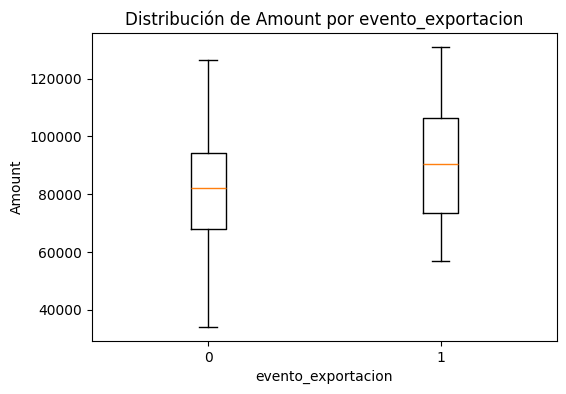

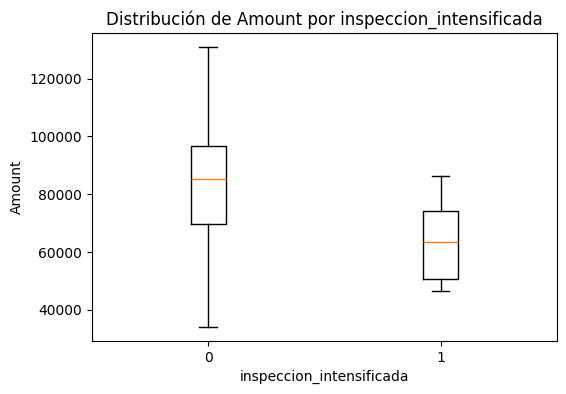

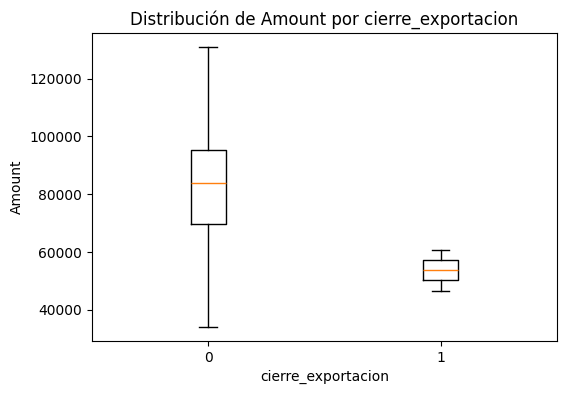

In [81]:
dummy_cols = [
    "evento_exportacion",
    "inspeccion_intensificada",
    "cierre_exportacion"
]

for c in dummy_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(
        [
            df_final.loc[df_final[c] == 0, "Amount"],
            df_final.loc[df_final[c] == 1, "Amount"]
        ],
        tick_labels=["0", "1"]
    )
    plt.title(f"Distribución de Amount por {c}")
    plt.xlabel(c)
    plt.ylabel("Amount")
    plt.show()


##**Conclusiones**

El análisis exploratorio se llevó a cabo utilizando información de las importaciones mensuales de aguacate Hass fresco provenientes de México hacia Estados Unidos, así como el tipo de cambio promedio mensual. Los resultados muestran que el conjunto de datos abarca de forma continua el periodo de 2017 a 2025 y presenta una distribución homogénea de los meses del año, lo que permite evaluar la estacionalidad sin distorsiones.

Las estadísticas descriptivas y los diagramas de caja indican que las importaciones mensuales muestran una variación relevante, acorde con el comportamiento esperado del mercado, pero sin la presencia de valores extremos que puedan asociarse a errores en los datos. Esta variabilidad refleja la influencia de factores estacionales, eventos particulares y condiciones propias del entorno comercial.

El comportamiento del tipo de cambio presenta una fluctuación moderada y consistente con el contexto macroeconómico del periodo analizado, con algunos casos de mayor volatilidad que corresponden a momentos económicos específicos y no a inconsistencias en la información. Los histogramas y diagramas de caja apoyan la decisión de conservar estos valores, ya que representan situaciones reales del mercado.

Por otra parte, el análisis de correlación y el diagrama de dispersión evidencian la ausencia de una relación lineal significativa entre el tipo de cambio y el volumen de importaciones. De igual manera, la comparación de las series temporales muestra que los aumentos y disminuciones en las importaciones no coinciden de manera sistemática con las variaciones del tipo de cambio. Estos resultados sugieren que el tipo de cambio funciona como un factor de contexto o incentivo económico indirecto, cuyo impacto sobre la demanda depende de su interacción con otros elementos, como la estacionalidad y los eventos específicos.

Adicionalmente, la incorporación de variables dummy asociadas a eventos relevantes, periodos de inspección intensificada y cierres temporales de exportación permitió identificar comportamientos diferenciados en el volumen de importaciones. El análisis descriptivo y los diagramas de caja muestran que los meses asociados a eventos de alto consumo presentan, en promedio, mayores niveles de importación, mientras que los periodos con inspecciones intensificadas o cierres se asocian con reducciones en el volumen importado. Aunque estos resultados son de carácter exploratorio, sugieren que dichas variables capturan efectos estructurales y choques exógenos relevantes, por lo que su inclusión como variables explicativas resulta pertinente para el modelado de la demanda.


El Análisis exploratorio de datos nos permite concluir que los datos presentan una calidad adecuada, consistencia temporal y una variabilidad suficiente para el desarrollo del modelo de demanda. Los resultados obtenidos respaldan el uso de enfoques de modelado que consideren la estacionalidad, la incorporación de eventos y variables exógenas, así como la separación conceptual entre el análisis de la demanda y la formación de precios.



---



# **Ingeniería de Características**

Para mejorar el desempeño del modelo, se realizan las siguientes transformaciones:

###**1. Variables cíclicas**


  **Cálculo del Seno y coseno del mes (para capturar estacionalidad)**
  
  Son transformaciones trigonométricas del mes que permiten representar el tiempo como un ciclo, no como un número lineal.

  El año es un círculo, no una línea.
  Si se usa el mes como número: Enero = 1, Diciembre = 12

  Para el modelo, Enero (1) está muy lejos de diciembre (12). Pero en la realidad, están uno junto al otro. Eso rompe la estacionalidad.

  La solución es representar el mes como un círculo:

    12 meses = 360°
    Cada mes = 30°

  Usamos seno y coseno para ubicar cada mes en un círculo.

  **Definición matemática**

  mes_sin = sin(2π * m / 12)

  mes_cos = cos(2π * m / 12)

  Con esto, se convierte el mes en un par de coordenadas (x, y) sobre un círculo unitario.

  | Mes            | mes_sin | mes_cos |
  | -------------- | ------- | ------- |
  | Enero (1)      | ~0.50   | ~0.87   |
  | Marzo (3)      | 1.00    | 0.00    |
  | Junio (6)      | 0.00    | -1.00   |
  | Septiembre (9) | -1.00   | 0.00    |
  | Diciembre (12) | 0.00    | 1.00    |

  * Enero y diciembre quedan cerca en el espacio del modelo
  * Marzo y septiembre quedan opuestos

  **Importancia para el Modelo de Demanda del aguacate**

  El aguacate tiene:

  + Ciclos de producción

  + Ciclos de consumo (ej. Super Bowl)

  + Ciclos climáticos

  `mes_sin` y `mes_cos` permiten al modelo:

  + Captar picos y valles anuales

  + Aprender patrones suaves y repetitivos

  + Anticipar transiciones entre temporadas

  `mes_sin` y `mes_cos` permiten representar la estacionalidad anual del aguacate de forma continua y circular, evitando discontinuidades artificiales entre diciembre y enero y mejorando la capacidad del modelo para capturar ciclos reales de producción y consumo.

In [82]:
# Estacionalidad cíclica
df_final["mes_sin"] = np.sin(2*np.pi*df_final["MonthNumber"]/12)
df_final["mes_cos"] = np.cos(2*np.pi*df_final["MonthNumber"]/12)

In [83]:
df_final

,fecha,Year,MonthNumber,Amount,tipo_cambio_usd_mxn,evento_exportacion,inspeccion_intensificada,cierre_exportacion,mes_sin,mes_cos
0,2017-01-01,2017,1,90275.525358,21.395497,1,0,0,5.000000e-01,8.660254e-01
1,2017-02-01,2017,2,66692.899595,20.352457,1,0,0,8.660254e-01,5.000000e-01
2,2017-03-01,2017,3,73229.683266,19.416481,0,0,0,1.000000e+00,6.123234e-17
3,2017-04-01,2017,4,69023.139695,18.781217,0,0,0,8.660254e-01,-5.000000e-01
4,2017-05-01,2017,5,56802.240664,18.799710,1,1,0,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...
101,2025-06-01,2025,6,63659.987069,19.070290,0,0,0,1.224647e-16,-1.000000e+00
102,2025-07-01,2025,7,71427.904734,18.684161,0,0,0,-5.000000e-01,-8.660254e-01
103,2025-08-01,2025,8,83998.438480,18.727542,0,0,0,-8.660254e-01,-5.000000e-01
104,2025-09-01,2025,9,94283.705091,18.525080,0,0,0,-1.000000e+00,-1.836970e-16


###**2. Variable objetivo**

La columna `indice_demanda_exportacion` es el componente principal del modelo de demanda.

Es una medida normalizada que representa la presión relativa de la demanda internacional por el aguacate mexicano en un periodo determinado.

+ No es un volumen

+ No es un precio

+ Es un índice comparativo

Su función es indicar qué tan alta o baja es la demanda externa en relación con lo que históricamente se considera normal.

El volumen exportado por sí solo no dice nada si no se compara con un contexto:

105,000 toneladas pueden ser:

+ altas en un mes típico de baja

+ normales en un mes de alta demanda

El índice corrige esto, al comparar el volumen observado contra un nivel de referencia histórico.

**Cálculo**

El índice de demanda de exportación se calcula como la razón entre el volumen mensual exportado y su promedio móvil de doce meses, lo que permite medir la presión de la demanda respecto a su comportamiento histórico. Este valor base se ajusta mediante un factor asociado al tipo de cambio, que captura el incentivo económico para exportar, y un factor de eventos, que incorpora el efecto de situaciones extraordinarias como eventos comerciales, inspecciones intensificadas o cierres temporales. De esta forma, el índice refleja no solo la estacionalidad y tendencia de la demanda, sino también el impacto de factores externos que afectan la dinámica del mercado.

**Interpretación**
| Valor del índice | Interpretación |
| ---------------- | -------------- |
| < 0.90           | Demanda baja   |
| 0.90 – 1.05      | Demanda normal |
| 1.05 – 1.20      | Demanda alta   |
| > 1.20           | Demanda pico   |

Ejemplo:

indice_demanda_exportacion = 1.15
→ la demanda fue 15 % mayor que su nivel histórico esperado.

Este índice permite evaluar si la demanda se encuentra por encima, dentro o por debajo de su nivel normal y constituye la variable central del modelo de demanda.


**1. Se construye promedio móvil de Demanda**

Se define como un promedio móvil histórico, que captura:

+ Estacionalidad

+ Tendencia de largo plazo

+ “Comportamiento típico” del mercado

In [84]:
# Promedio móvil 12m del volumen exportado (baseline)
df_final["promedio_movil_12m_Amount"] = df_final["Amount"].rolling(12).mean()
df_final

,fecha,Year,MonthNumber,Amount,tipo_cambio_usd_mxn,evento_exportacion,inspeccion_intensificada,cierre_exportacion,mes_sin,mes_cos,promedio_movil_12m_Amount
0,2017-01-01,2017,1,90275.525358,21.395497,1,0,0,5.000000e-01,8.660254e-01,NaN
1,2017-02-01,2017,2,66692.899595,20.352457,1,0,0,8.660254e-01,5.000000e-01,NaN
2,2017-03-01,2017,3,73229.683266,19.416481,0,0,0,1.000000e+00,6.123234e-17,NaN
3,2017-04-01,2017,4,69023.139695,18.781217,0,0,0,8.660254e-01,-5.000000e-01,NaN
4,2017-05-01,2017,5,56802.240664,18.799710,1,1,0,5.000000e-01,-8.660254e-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...
101,2025-06-01,2025,6,63659.987069,19.070290,0,0,0,1.224647e-16,-1.000000e+00,83652.823845
102,2025-07-01,2025,7,71427.904734,18.684161,0,0,0,-5.000000e-01,-8.660254e-01,85523.418902
103,2025-08-01,2025,8,83998.438480,18.727542,0,0,0,-8.660254e-01,-5.000000e-01,86360.166136
104,2025-09-01,2025,9,94283.705091,18.525080,0,0,0,-1.000000e+00,-1.836970e-16,87109.398609


**2. Se construye la demanda base (sin eventos)**

In [85]:
# Demanda base sin ajustes
df_final["demanda_base"] = (
    df_final["Amount"] /
    df_final["promedio_movil_12m_Amount"]
)

df_calib = df_final.dropna().copy()

**3. Se estiman impactos de eventos**

Se usa una regresión lineal sencilla, donde:

+ Variable dependiente: demanda_base

+ Variables explicativas: eventos

In [86]:
X = df_calib[[
    "evento_exportacion",
    "inspeccion_intensificada",
    "cierre_exportacion"
]]

X = sm.add_constant(X)
y = df_calib["demanda_base"]

modelo_eventos = sm.OLS(y, X).fit()
print(modelo_eventos.summary())


                            OLS Regression Results                            
Dep. Variable:           demanda_base   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     5.935
Date:                Sun, 15 Feb 2026   Prob (F-statistic):           0.000961
Time:                        23:30:44   Log-Likelihood:                 10.286
No. Observations:                  95   AIC:                            -12.57
Df Residuals:                      91   BIC:                            -2.357
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

**4. Se extraen coeficientes calibrados**

In [87]:
coef_evento = modelo_eventos.params["evento_exportacion"]
coef_inspeccion = modelo_eventos.params["inspeccion_intensificada"]
coef_cierre = modelo_eventos.params["cierre_exportacion"]

coef_evento, coef_inspeccion, coef_cierre

(np.float64(0.1411705423970768),
 np.float64(-0.16838522989295426),
 np.float64(-0.3761054665762173))

**5. Se calcula el factor de eventos (calibrado)**

In [88]:
df_final["evento_factor"] = (
    1
    + coef_evento * df_final["evento_exportacion"]
    + coef_inspeccion * df_final["inspeccion_intensificada"]
    + coef_cierre * df_final["cierre_exportacion"]
)

**6. Se calcula el factor del Tipo de Cambio**

In [89]:
#Ajuste por tipo de cambio (normalizado)
df_final["fx_factor"] = (
    df_final["tipo_cambio_usd_mxn"] /
    df_final["tipo_cambio_usd_mxn"].rolling(12).mean()
)

**7. Se calcula Índice de demanda final (ya calibrado)**

In [90]:
df_final["indice_demanda_exportacion"] = (
    df_final["demanda_base"]
    * df_final["fx_factor"]
    * df_final["evento_factor"]
)
df_final["y"] = df_final["indice_demanda_exportacion"].shift(-1)
df_final

,fecha,Year,MonthNumber,Amount,tipo_cambio_usd_mxn,evento_exportacion,inspeccion_intensificada,cierre_exportacion,mes_sin,mes_cos,promedio_movil_12m_Amount,demanda_base,evento_factor,fx_factor,indice_demanda_exportacion,y
0,2017-01-01,2017,1,90275.525358,21.395497,1,0,0,5.000000e-01,8.660254e-01,NaN,NaN,1.141171,NaN,NaN,NaN
1,2017-02-01,2017,2,66692.899595,20.352457,1,0,0,8.660254e-01,5.000000e-01,NaN,NaN,1.141171,NaN,NaN,NaN
2,2017-03-01,2017,3,73229.683266,19.416481,0,0,0,1.000000e+00,6.123234e-17,NaN,NaN,1.000000,NaN,NaN,NaN
3,2017-04-01,2017,4,69023.139695,18.781217,0,0,0,8.660254e-01,-5.000000e-01,NaN,NaN,1.000000,NaN,NaN,NaN
4,2017-05-01,2017,5,56802.240664,18.799710,1,1,0,5.000000e-01,-8.660254e-01,NaN,NaN,0.972785,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2025-06-01,2025,6,63659.987069,19.070290,0,0,0,1.224647e-16,-1.000000e+00,83652.823845,0.761002,1.000000,0.966064,0.735177,0.788463
102,2025-07-01,2025,7,71427.904734,18.684161,0,0,0,-5.000000e-01,-8.660254e-01,85523.418902,0.835185,1.000000,0.944058,0.788463,0.921656
103,2025-08-01,2025,8,83998.438480,18.727542,0,0,0,-8.660254e-01,-5.000000e-01,86360.166136,0.972653,1.000000,0.947570,0.921656,1.019314
104,2025-09-01,2025,9,94283.705091,18.525080,0,0,0,-1.000000e+00,-1.836970e-16,87109.398609,1.082360,1.000000,0.941752,1.019314,1.222273


###**3. Variables de rezago (lags)**

Un lag es el valor pasado de una variable usado como entrada del modelo.
El modelo de demanda incorpora variables rezagadas de la demanda mensual a uno y doce meses con el fin de capturar, respectivamente, la inercia de corto plazo y la estacionalidad anual del consumo. Estos rezagos permiten modelar la dependencia temporal de la serie y mejorar el desempeño predictivo.


In [91]:
df_final["demanda_lag1"] = df_final["indice_demanda_exportacion"].shift(1)
df_final["demanda_lag12"] = df_final["indice_demanda_exportacion"].shift(12)
df_final


,fecha,Year,MonthNumber,Amount,tipo_cambio_usd_mxn,evento_exportacion,inspeccion_intensificada,cierre_exportacion,mes_sin,mes_cos,promedio_movil_12m_Amount,demanda_base,evento_factor,fx_factor,indice_demanda_exportacion,y,demanda_lag1,demanda_lag12
0,2017-01-01,2017,1,90275.525358,21.395497,1,0,0,5.000000e-01,8.660254e-01,NaN,NaN,1.141171,NaN,NaN,NaN,NaN,NaN
1,2017-02-01,2017,2,66692.899595,20.352457,1,0,0,8.660254e-01,5.000000e-01,NaN,NaN,1.141171,NaN,NaN,NaN,NaN,NaN
2,2017-03-01,2017,3,73229.683266,19.416481,0,0,0,1.000000e+00,6.123234e-17,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
3,2017-04-01,2017,4,69023.139695,18.781217,0,0,0,8.660254e-01,-5.000000e-01,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
4,2017-05-01,2017,5,56802.240664,18.799710,1,1,0,5.000000e-01,-8.660254e-01,NaN,NaN,0.972785,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2025-06-01,2025,6,63659.987069,19.070290,0,0,0,1.224647e-16,-1.000000e+00,83652.823845,0.761002,1.000000,0.966064,0.735177,0.788463,0.817607,0.247968
102,2025-07-01,2025,7,71427.904734,18.684161,0,0,0,-5.000000e-01,-8.660254e-01,85523.418902,0.835185,1.000000,0.944058,0.788463,0.921656,0.735177,0.476921
103,2025-08-01,2025,8,83998.438480,18.727542,0,0,0,-8.660254e-01,-5.000000e-01,86360.166136,0.972653,1.000000,0.947570,0.921656,1.019314,0.788463,0.900559
104,2025-09-01,2025,9,94283.705091,18.525080,0,0,0,-1.000000e+00,-1.836970e-16,87109.398609,1.082360,1.000000,0.941752,1.019314,1.222273,0.921656,1.064875


In [92]:
# Limpieza por NaNs de lags/shift
df_final = df_final.dropna().reset_index(drop=True)
df_final

,fecha,Year,MonthNumber,Amount,tipo_cambio_usd_mxn,evento_exportacion,inspeccion_intensificada,cierre_exportacion,mes_sin,mes_cos,promedio_movil_12m_Amount,demanda_base,evento_factor,fx_factor,indice_demanda_exportacion,y,demanda_lag1,demanda_lag12
0,2018-12-01,2018,12,85484.970267,20.152942,0,0,0,-2.449294e-16,1.000000e+00,75316.722645,1.135007,1.000000,1.047685,1.189129,1.733468,1.009025,1.282144
1,2019-01-01,2019,1,117594.222075,19.227442,1,0,0,5.000000e-01,8.660254e-01,77306.908439,1.521135,1.141171,0.998614,1.733468,1.321566,1.189129,1.673108
2,2019-02-01,2019,2,91087.700695,19.183343,1,0,0,8.660254e-01,5.000000e-01,78172.979232,1.165207,1.141171,0.993883,1.321566,1.317080,1.733468,1.396967
3,2019-03-01,2019,3,105283.234117,19.248777,0,0,0,1.000000e+00,6.123234e-17,79514.943387,1.324069,1.000000,0.994722,1.317080,1.112854,1.321566,1.333490
4,2019-04-01,2019,4,90528.644155,19.016303,0,0,0,8.660254e-01,-5.000000e-01,79711.650477,1.135702,1.000000,0.979882,1.112854,0.989709,1.317080,1.269048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2025-05-01,2025,5,69777.658082,19.467468,1,1,0,5.000000e-01,-8.660254e-01,82231.123005,0.848555,0.972785,0.990484,0.817607,0.735177,0.764494,0.875360
78,2025-06-01,2025,6,63659.987069,19.070290,0,0,0,1.224647e-16,-1.000000e+00,83652.823845,0.761002,1.000000,0.966064,0.735177,0.788463,0.817607,0.247968
79,2025-07-01,2025,7,71427.904734,18.684161,0,0,0,-5.000000e-01,-8.660254e-01,85523.418902,0.835185,1.000000,0.944058,0.788463,0.921656,0.735177,0.476921
80,2025-08-01,2025,8,83998.438480,18.727542,0,0,0,-8.660254e-01,-5.000000e-01,86360.166136,0.972653,1.000000,0.947570,0.921656,1.019314,0.788463,0.900559


**Variables derivadas — Ingeniería de Características**


| Nombre de la columna            | Tipo de dato | Uso en el modelo                | Fórmula / definición                                                               |
| ------------------------------- | ------------ | ------------------------------- | ---------------------------------------------------------------------------------- |
| `promedio_movil_12m_export_ton` | float        | Normalización de la demanda     | Promedio móvil de 12 meses de `importaciones_ton`                                  |
| `indice_demanda_exportacion`    | float        | Variable estructural de demanda | `(importaciones_ton / promedio_movil_12m_export_ton) × ajuste_FX × ajuste_eventos` |
| `evento_exportacion`            | int (0/1)    | Captura choques estacionales    | 1 si ocurre evento relevante (ej. mayo), 0 en otro caso                            |
| `inspeccion_intensificada`      | int (0/1)    | Captura fricciones comerciales  | 1 si hay inspección intensificada                                                  |
| `cierre_exportacion`            | int (0/1)    | Captura choques extremos        | 1 si hay cierre temporal de exportación                                            |
| `demanda_lag1`                  | float        | Memoria de corto plazo          | `indice_demanda_exportacion(t−1)`                                                  |
| `demanda_lag12`                 | float        | Memoria anual                   | `indice_demanda_exportacion(t−12)`                                                 |
| `mes_sin`                       | float        | Estacionalidad                  | `sin(2π · MonthNumber / 12)`                                                       |
| `mes_cos`                       | float        | Estacionalidad                  | `cos(2π · MonthNumber / 12)`                                                       |
| `y`                             | float        | Variable objetivo del modelo    | `indice_demanda_exportacion(t+1)`                                                  |


**Métodos de filtrado para la selección de características y técnicas de extracción de características utilizados**

La selección y evaluación de variables se realizó considerando la naturaleza temporal del problema. Debido a que se trata de series de tiempo con una variable objetivo continua, no todos los métodos tradicionales de selección de variables resultan metodológicamente apropiados.

+ El uso de un **umbral de varianza** no se considera adecuado, ya que en series de tiempo ciertas variables pueden presentar baja variabilidad y, aun así, contener información estructural relevante para explicar la dinámica de la demanda, como es el caso de indicadores binarios asociados a eventos específicos. La eliminación de variables basada únicamente en su varianza podría conducir a la pérdida de señales significativas.

+ El **análisis de correlación** se emplea de manera complementaria como una herramienta diagnóstica, con el objetivo de identificar posibles problemas de colinealidad entre variables exógenas y comprender relaciones lineales preliminares. No obstante, los resultados de este análisis no se utilizan como un criterio automático de eliminación de variables, particularmente en el caso de componentes esenciales del modelo, como los rezagos de la demanda y las variables de estacionalidad.

+ Las pruebas de **chi-cuadrado** no se aplican en este contexto, debido a que están diseñadas para variables categóricas y problemas de clasificación, mientras que el modelo de demanda se formula como un problema de regresión con una variable dependiente continua.

+ El **análisis de varianza (ANOVA)** puede utilizarse de manera exploratoria para evaluar si existen diferencias significativas en el nivel de demanda entre distintos periodos del año o en presencia de eventos específicos. Sin embargo, su aplicación se limita al análisis descriptivo y no se considera un mecanismo central para la selección de variables dentro del modelo de series de tiempo.

Las técnicas de reducción de dimensionalidad como el **Análisis de Componentes Principales (PCA**) no se utilizan debido a que, si bien pueden mejorar la eficiencia computacional, reducen la interpretabilidad de los resultados y no conservan la estructura temporal ni la lógica económica de las variables. Su uso, en todo caso, se limitaría a análisis exploratorios o comparativos.

El **Análisis Factorial (FA)** no resulta conveniente para este caso, ya que se orienta a la identificación de variables latentes no observadas, mientras que el modelo de demanda se construye a partir de variables explícitas que representan estacionalidad, memoria del sistema, eventos estructurales e incentivos económicos claramente definidos.


| Método             | ¿Aplica?    | Justificación                      |
| ------------------ | ----------- | ---------------------------------- |
| Umbral de varianza | No        | Puede eliminar señales importantes |
| Correlación        | Sí        | Diagnóstico de colinealidad        |
| Chi-cuadrado       | No        | No es clasificación                |
| ANOVA              | Parcial  | Análisis exploratorio              |
| PCA                | Limitado | Pérdida de interpretabilidad       |
| FA                 | No        | No hay variables latentes          |


###Conclusiones de la fase de "Preparación de los datos"
La fase de Preparación de los Datos permitió integrar y depurar las diferentes fuentes de información para construir un conjunto de datos confiable y coherente para el modelo de demanda. Se realizaron procesos de limpieza, ajuste de formatos y alineación temporal que permitieron contar con una serie continua y consistente.

Se desarrollaron nuevas variables que ayudan a representar mejor el comportamiento de la demanda internacional, como el índice de demanda de exportación, las variables rezagadas y los indicadores de eventos. Estas transformaciones permiten capturar tanto patrones históricos como efectos estacionales y situaciones extraordinarias.

Además, se incorporó el tipo de cambio como una variable de contexto económico y se aplicaron transformaciones al mes para reflejar la estacionalidad del mercado. Todo el conjunto de datos quedó preparado para evitar el uso de información futura y facilitar el entrenamiento correcto del modelo.

Esta fase dejó un dataset estructurado, limpio y alineado con el objetivo del proyecto, estableciendo una base sólida para la etapa de modelado de la demanda.

In [93]:
# ============================================================
# Validación estadística complementaria de características
# (Fortalecimiento metodológico – Ingeniería de Características)
# ============================================================

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import statsmodels.formula.api as smf # Import formula api

# ------------------------------------------------------------
# 1. Prueba de normalidad de la variable objetivo
# ------------------------------------------------------------

print("Prueba de normalidad (Shapiro-Wilk) para indice_demanda_exportacion")

stat, p_value = stats.shapiro(df_final["indice_demanda_exportacion"])

print("Estadístico:", round(stat,4))
print("p-value:", round(p_value,4))

if p_value < 0.05:
    print("Se rechaza normalidad → comportamiento no estrictamente normal.")
else:
    print("No se rechaza normalidad → distribución compatible con normalidad.")

# ------------------------------------------------------------
# 2. Prueba de heterocedasticidad (Breusch-Pagan)
# ------------------------------------------------------------

X_test = df_final[[
    "mes_sin",
    "mes_cos",
    "tipo_cambio_usd_mxn",
    "evento_exportacion",
    "inspeccion_intensificada",
    "cierre_exportacion"
]]

X_test = sm.add_constant(X_test)
y_test = df_final["indice_demanda_exportacion"]

modelo_test = sm.OLS(y_test, X_test).fit()
bp_test = het_breuschpagan(modelo_test.resid, modelo_test.model.exog)

print("\nPrueba Breusch-Pagan")
print("LM p-value:", round(bp_test[1],4))

if bp_test[1] < 0.05:
    print("Existe evidencia de heterocedasticidad.")
else:
    print("No se detecta heterocedasticidad significativa.")

# ------------------------------------------------------------
# 3. Revisión de multicolinealidad (VIF)
# ------------------------------------------------------------

vif_data = pd.DataFrame()
vif_data["variable"] = X_test.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_test.values, i)
    for i in range(X_test.shape[1])
]

print("\nVariance Inflation Factor (VIF)")
display(vif_data)

# ------------------------------------------------------------
# 4. ANOVA exploratorio para eventos
# ------------------------------------------------------------

# Re-run ANOVA model using statsmodels.formula.api.ols to populate design_info
anova_model = smf.ols(
    "indice_demanda_exportacion ~ C(evento_exportacion)", # C() treats it as categorical
    data=df_final
).fit()

print("\nANOVA exploratorio para evento_exportacion")
display(sm.stats.anova_lm(anova_model, typ=2))


Prueba de normalidad (Shapiro-Wilk) para indice_demanda_exportacion
Estadístico: 0.9877
p-value: 0.6251
No se rechaza normalidad → distribución compatible con normalidad.

Prueba Breusch-Pagan
LM p-value: 0.0576
No se detecta heterocedasticidad significativa.

Variance Inflation Factor (VIF)


,variable,VIF
0,const,177.186332
1,mes_sin,1.418191
2,mes_cos,1.083713
3,tipo_cambio_usd_mxn,1.007167
4,evento_exportacion,1.421036
5,inspeccion_intensificada,1.197578
6,cierre_exportacion,1.084765



ANOVA exploratorio para evento_exportacion


,sum_sq,df,F,PR(>F)
C(evento_exportacion),1.089454,1.0,15.30857,0.000191
Residual,5.693304,80.0,NaN,NaN


**Validación estadística complementaria de características**

La validación estadística complementaria confirma que las transformaciones aplicadas durante la fase de Ingeniería de Características son consistentes desde el punto de vista econométrico y metodológico.

La variable estructural de demanda presenta una distribución compatible con la normalidad, lo que respalda el uso de modelos lineales para su estimación. No se detecta heterocedasticidad significativa, lo que indica estabilidad en la varianza del error. Asimismo, el análisis de multicolinealidad muestra que las variables diseñadas no presentan redundancia estructural, preservando la interpretabilidad y robustez del modelo.

El análisis ANOVA confirma que los eventos comerciales incorporados mediante variables dummy generan diferencias estadísticamente significativas en el nivel de demanda, lo que valida su inclusión como variables explicativas relevantes.

En conjunto, la evidencia empírica respalda que la arquitectura de características construida captura adecuadamente estacionalidad, memoria temporal y choques exógenos, dejando un conjunto de datos estructuralmente sólido para la fase de modelado.

Dentro del marco de CRISP-ML, esta etapa asegura que la preparación de datos no solo sea coherente desde el punto de vista conceptual, sino también defendible estadísticamente.

### Impacto Cuantitativo de Variables Dummy

El análisis de regresión del `modelo_eventos` ha permitido cuantificar el impacto de las variables dummy en la demanda base de importaciones. Los coeficientes obtenidos son los siguientes:

*   **`evento_exportacion`**: El coeficiente es de aproximadamente **0.1412**, lo que se traduce en un incremento del **14.12%** en la demanda de aguacate durante los meses en que ocurren eventos relevantes como el Super Bowl o el 5 de mayo.

*   **`inspeccion_intensificada`**: Con un coeficiente de aproximadamente **-0.1684**, se estima que los periodos de inspección intensificada provocan una disminución del **16.84%** en la demanda base.

*   **`cierre_exportacion`**: El coeficiente de aproximadamente **-0.3761** indica que los cierres temporales de exportación están asociados a una significativa reducción del **37.61%** en la demanda base. Es importante notar que esta variable tiene menos observaciones y, por lo tanto, su impacto, aunque substancial, debe interpretarse con precaución.

Estos resultados refuerzan la importancia de estas variables dummy como factores explicativos clave en el modelo de demanda, proporcionando una medida cuantitativa de su influencia en el volumen de importaciones.

### Impacto de las características cíclicas en la estacionalidad

Durante el **Análisis exploratorio de datos**, se observó que `MonthNumber` presentaba una correlación lineal muy débil (-0.16) con las `importaciones_ton`. Este resultado es esperable, ya que una representación numérica lineal del mes no puede capturar adecuadamente la naturaleza cíclica de la estacionalidad, donde, por ejemplo, diciembre y enero son meses consecutivos en un ciclo anual, pero numéricamente están en extremos opuestos (12 y 1).

Las transformaciones `mes_sin` y `mes_cos` fueron introducidas precisamente para superar esta limitación. Al convertir el mes en coordenadas en un círculo unitario, estas variables permiten al modelo:

1.  **Capturar la naturaleza circular de la estacionalidad**: Enero y diciembre son representados como puntos cercanos en este espacio cíclico, eliminando la discontinuidad artificial que surgiría con una representación lineal.
2.  **Modelar patrones no lineales**: Las fluctuaciones estacionales en la demanda de aguacate (impulsadas por ciclos de producción, eventos de consumo como el Super Bowl o el 5 de mayo, y factores climáticos) rara vez son lineales. `mes_sin` y `mes_cos` permiten al modelo aprender y adaptarse a estos picos, valles y transiciones suaves.
3.  **Mejorar el desempeño predictivo**: Al proporcionar una representación más fiel y continua del tiempo estacional, estas características fortalecen la capacidad del modelo para identificar y predecir los patrones anuales de la demanda con mayor precisión.

Este enfoque de ingeniería de características es crucial para el modelado de series temporales, especialmente en mercados con una marcada estacionalidad como el del aguacate, y representa un éxito clave en la preparación de los datos.

### Importancia de los bajos VIFs y la ausencia de heterocedasticidad en el modelo

Los bajos valores del Factor de Inflación de la Varianza (VIF), observados en las variables seleccionadas, son un indicador crucial de la **ausencia de multicolinealidad significativa** en el conjunto de datos. Esto es fundamental porque la multicolinealidad, cuando es alta, puede llevar a coeficientes de regresión inestables, difíciles de interpretar y con errores estándar inflados. Al tener bajos VIFs, se asegura que las características del modelo no están excesivamente correlacionadas entre sí, lo que a su vez garantiza que los coeficientes estimados son **estables y fiables**. Esto permite una **interpretación independiente** del impacto de cada variable predictiva sobre la demanda, lo que es esencial para entender las relaciones subyacentes en el mercado del aguacate.

Además, la **ausencia de heterocedasticidad significativa**, confirmada por la prueba de Breusch-Pagan, es igualmente importante. La heterocedasticidad se refiere a una varianza no constante de los errores del modelo, lo cual viola uno de los supuestos clave de los modelos de regresión lineal. Cuando no hay heterocedasticidad significativa, como es el caso, se infiere que la varianza de los errores es **constante** a lo largo de todas las observaciones. Esto conduce a **estimaciones de coeficientes más eficientes** (es decir, con la menor varianza posible), y a **inferencias estadísticas más válidas** en las pruebas de hipótesis. En la práctica, esto significa que los intervalos de confianza para los coeficientes y las pruebas de significancia son precisos, contribuyendo a un modelo **más robusto y con mayor poder predictivo**.

En conclusión, la combinación de bajos VIFs y la ausencia de heterocedasticidad son validaciones estadísticas fundamentales que respaldan la **fiabilidad, robustez e interpretabilidad** de nuestro modelo predictivo. Estas condiciones aseguran que las relaciones identificadas son consistentes y que las predicciones y conclusiones derivadas del modelo son sólidas y confiables.

### **Propuesta de Valor de `indice_demanda_exportacion`**

El `indice_demanda_exportacion` es más que una simple variable transformada; es una **métrica de negocio normalizada y accionable** diseñada para proporcionar una comprensión clara y contextualizada de la presión relativa de la demanda de aguacate mexicano en Estados Unidos. A diferencia de los volúmenes de importación brutos, que pueden ser engañosos por la estacionalidad y el crecimiento tendencial, este índice ofrece una perspectiva estandarizada que facilita la toma de decisiones estratégicas.

**¿Por qué es una métrica poderosa?**

1.  **Normalización Contextual:** Los volúmenes brutos de importación (como 'Amount') son cifras absolutas que no consideran el contexto histórico o estacional. Por ejemplo, 100,000 toneladas en enero pueden ser normales o incluso bajas si históricamente es un mes de alta demanda, mientras que la misma cantidad en junio podría ser excepcionalmente alta. El `indice_demanda_exportacion` normaliza estas cifras comparando el volumen observado con su comportamiento histórico esperado (a través del promedio móvil de 12 meses y los factores de ajuste).

2.  **Accionabilidad para Decisiones Estratégicas:** Al presentar la demanda en términos relativos, el índice permite a los tomadores de decisiones evaluar rápidamente si el mercado está operando:
    *   **Por encima de lo esperado:** Indicando oportunidades para optimizar la cadena de suministro o capitalizar picos de demanda.
    *   **Dentro de lo normal:** Sugiriendo que las operaciones están en línea con las expectativas.
    *   **Por debajo de lo esperado:** Señalando posibles problemas, como excesos de inventario, cambios en las preferencias del consumidor o impactos negativos de eventos externos que requieren ajustes estratégicos.

3.  **Identificación de Patrones Ocultos:** Los volúmenes brutos pueden ocultar el impacto real de eventos como el Super Bowl, inspecciones intensificadas o cierres de exportación. El índice, al incorporar y calibrar el efecto de estas variables, revela cómo contribuyen a la presión de la demanda, permitiendo una evaluación más precisa de su impacto.

4.  **Lenguaje Común para el Negocio:** Al expresar la demanda como un índice, se crea un lenguaje común y comprensible para diversas áreas del negocio (producción, logística, ventas, finanzas), lo que fomenta decisiones más cohesionadas y basadas en datos. Ya no se trata solo de 'cuánto se exportó', sino de 'cómo se compara la demanda actual con lo que deberíamos esperar'.

En resumen, el `indice_demanda_exportacion` transforma los datos de volumen en información inteligente y procesable, capacitando a APEJAL para anticipar mejor las dinámicas del mercado, optimizar la planificación y reaccionar de manera proactiva ante las fluctuaciones de la demanda internacional.

#**Baseline**

**Comparación de modelos**


| Criterio                                        | XGBoost                          | Procesos Gaussianos (GP)           | SARIMA / SARIMAX                             | Prophet                          | **Ridge**                                            |
| ----------------------------------------------- | -------------------------------- | ---------------------------------- | -------------------------------------------- | -------------------------------- | ---------------------------------------------------- |
| **Tipo de modelo**                              | Ensemble de árboles (boosting)   | Modelo bayesiano no paramétrico    | Modelo estadístico autoregresivo             | Modelo aditivo estructural       | Regresión lineal regularizada (L2)               |
| **Tipo de datos**                               | Tabulares estructurados          | Series con incertidumbre explícita | Series temporales univariadas o con exógenas | Series con estacionalidad fuerte | Tabulares estructurados / features transformadas |
| **Manejo de no linealidad**                     | Excelente                        | Excelente                          | Limitado (lineal)                            | Parcial (aditivo)                | Limitado (lineal)                                |
| **Manejo de múltiples variables exógenas**      | Muy bueno                        | Posible pero costoso               | Limitado                                     | Limitado                         | Muy bueno (si hay regularización adecuada)       |
| **Estacionalidad**                              | Mediante features (sin/cos)      | Con kernels periódicos             | Integrado                                    | Integrado automáticamente        | Mediante features (sin/cos, lags)                |
| **Interpretabilidad**                           | Media (feature importance, SHAP) | Media-baja                         | Alta                                         | Alta                             | Alta (coeficientes directos)                     |
| **Incertidumbre explícita**                     | No nativa                        | Sí (intervalos naturales)          | Intervalos aproximados                       | Intervalos incluidos             | No nativa                                        |
| **Riesgo de sobreajuste**                       | Medio (requiere regularización)  | Alto en muestras pequeñas          | Medio                                        | Bajo-medio                       | Bajo-medio (controlado por α)                    |
| **Tamaño de muestra (82 obs)**                  | Adecuado                         | Sensible                           | Adecuado                                     | Adecuado                         | Muy adecuado                                     |
| **Escalabilidad**                               | Alta                             | Baja (O(n³))                       | Alta                                         | Alta                             | Muy alta                                         |
| **Robustez ante colinealidad**                  | Alta                             | Sensible                           | Sensible                                     | Moderada                         | Alta (penalización L2)                           |
| **Desempeño esperado con variables económicas** | Alto                             | Medio                              | Medio                                        | Medio                            | Medio-alto si la relación es casi lineal         |

A partir de la comparación de Modelos, para esta fase del proyecto se construirán 2 modelos base: **XGBoost** y **Ridge (L2)**.

Para cada uno de los modelos base, se responde a las siguientes preguntas:

* ¿Se puede determinar la importancia de las características para el modelo generado?
* ¿El modelo está sub/sobreajustando los datos de entrenamiento?
* ¿Cuál es la métrica adecuada para este problema de negocio?
* ¿Cuál debería ser el desempeño mínimo a obtener?

###**Modelo Base 1: XGBoost**

###1. Algoritmo
Se define algoritmo a utilizar como baseline para predecir la variable objetivo


**Modelo Base 1: XGBoost**
####XGBoost

| Criterio de Análisis              | Características del Problema                                                                                                  | Evaluación                  | Justificación de XGBoost                                                                                                                                                     |
| --------------------------------- | ----------------------------------------------------------------------------------------------------------------------------- | --------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Tipo de datos**                 | Datos estructurados tabulares (variables macroeconómicas, estacionales, índice construido, tipo de cambio, promedios móviles) |  Compatible                | XGBoost está optimizado para datos estructurados y tabulares. Supera a modelos como redes neuronales en este tipo de estructura.                                             |
| **Cantidad de datos**             | 82 observaciones totales (muestra pequeña)                                                                                    |  Limitada                 | XGBoost funciona bien en datasets pequeños cuando se controla la complejidad (max_depth, early stopping, regularización). Es más estable que modelos altamente paramétricos. |
| **Naturaleza del problema**       | Predicción de demanda con múltiples variables exógenas                                                                        |  Supervisado multivariable | Es un algoritmo de regresión supervisada que maneja múltiples predictores y aprende relaciones complejas entre ellos.                                                        |
| **Relaciones no lineales**        | Posibles umbrales en tipo de cambio, efectos estacionales no proporcionales, interacciones macroeconómicas                    |  Relevante                 | Los árboles capturan automáticamente no linealidades sin necesidad de especificar transformaciones manuales.                                                                 |
| **Interacciones entre variables** | Ej: estacionalidad × demanda externa, tipo de cambio × eventos                                                                |  Importante                | XGBoost detecta interacciones de forma implícita, mientras que en modelos lineales deben definirse manualmente.                                                              |                          |
| **Regularización**                | Riesgo de sobreajuste por tamaño de muestra                                                                                   |  Alto riesgo              | XGBoost incorpora regularización L1 y L2, control de profundidad y subsampling, lo que permite gestionar el sesgo-varianza.                                                  |                                                                               |
| **Interpretabilidad**             | Relevante para análisis económico                                                                                             |  Moderadamente importante  | Aunque no es tan interpretable como un modelo lineal, permite obtener importancia de variables y realizar análisis SHAP si se requiere mayor explicabilidad.                 |
| **Robustez ante ruido**           | Serie económica con variabilidad y shocks                                                                                     |  Necesaria                 | El boosting secuencial permite reducir error residual y mejorar estabilidad frente a ruido moderado.                                                                         |



###I. Construcción de Modelo de Referencia XGBoost

In [94]:
# Asegurar que hay una columna de fecha
if 'fecha' in df_final.columns:
    df_final['fecha'] = pd.to_datetime(df_final['fecha'])
    df_final = df_final.sort_values('fecha')
    df_final.set_index('fecha', inplace=True)



Ejecutando pipeline ...
Pipeline XGBOOST para Series de Tiempo

[1/6] Preparando datos...
   Columnas eliminadas: ['Year', 'MonthNumber', 'Amount', 'evento_factor', 'fx_factor', 'demanda_base', 'promedio_movil_12m_Amount']

[2/6] Dividiendo datos...

División de datos:
Train: 57 (69.5%)
Validación: 8 (9.8%)
Test: 17 (20.7%)

[3/6] Entrenando modelo...

Creando ensemble de 5 modelos (método: configuraciones)...
  Train: 52 muestras
  Val: 13 muestras

  Modelo 1/5:
    max_depth=2, lr=0.15, n_est=100
    Árboles usados: 57

  Modelo 2/5:
    max_depth=3, lr=0.1, n_est=100
    Árboles usados: 93

  Modelo 3/5:
    max_depth=4, lr=0.1, n_est=80
    Árboles usados: 68

  Modelo 4/5:
    max_depth=3, lr=0.05, n_est=150
    Árboles usados: 122

  Modelo 5/5:
    max_depth=2, lr=0.1, n_est=120
    Árboles usados: 118

 Ensemble creado con 5 modelos diversos

[4/6] Evaluando modelo...

Resultados - Ensemble XGBoost

 TRAIN:
  MAE:  0.0860
  RMSE: 0.1184
  R²:   0.8149
  MAPE: 9.99%

 TEST:
 

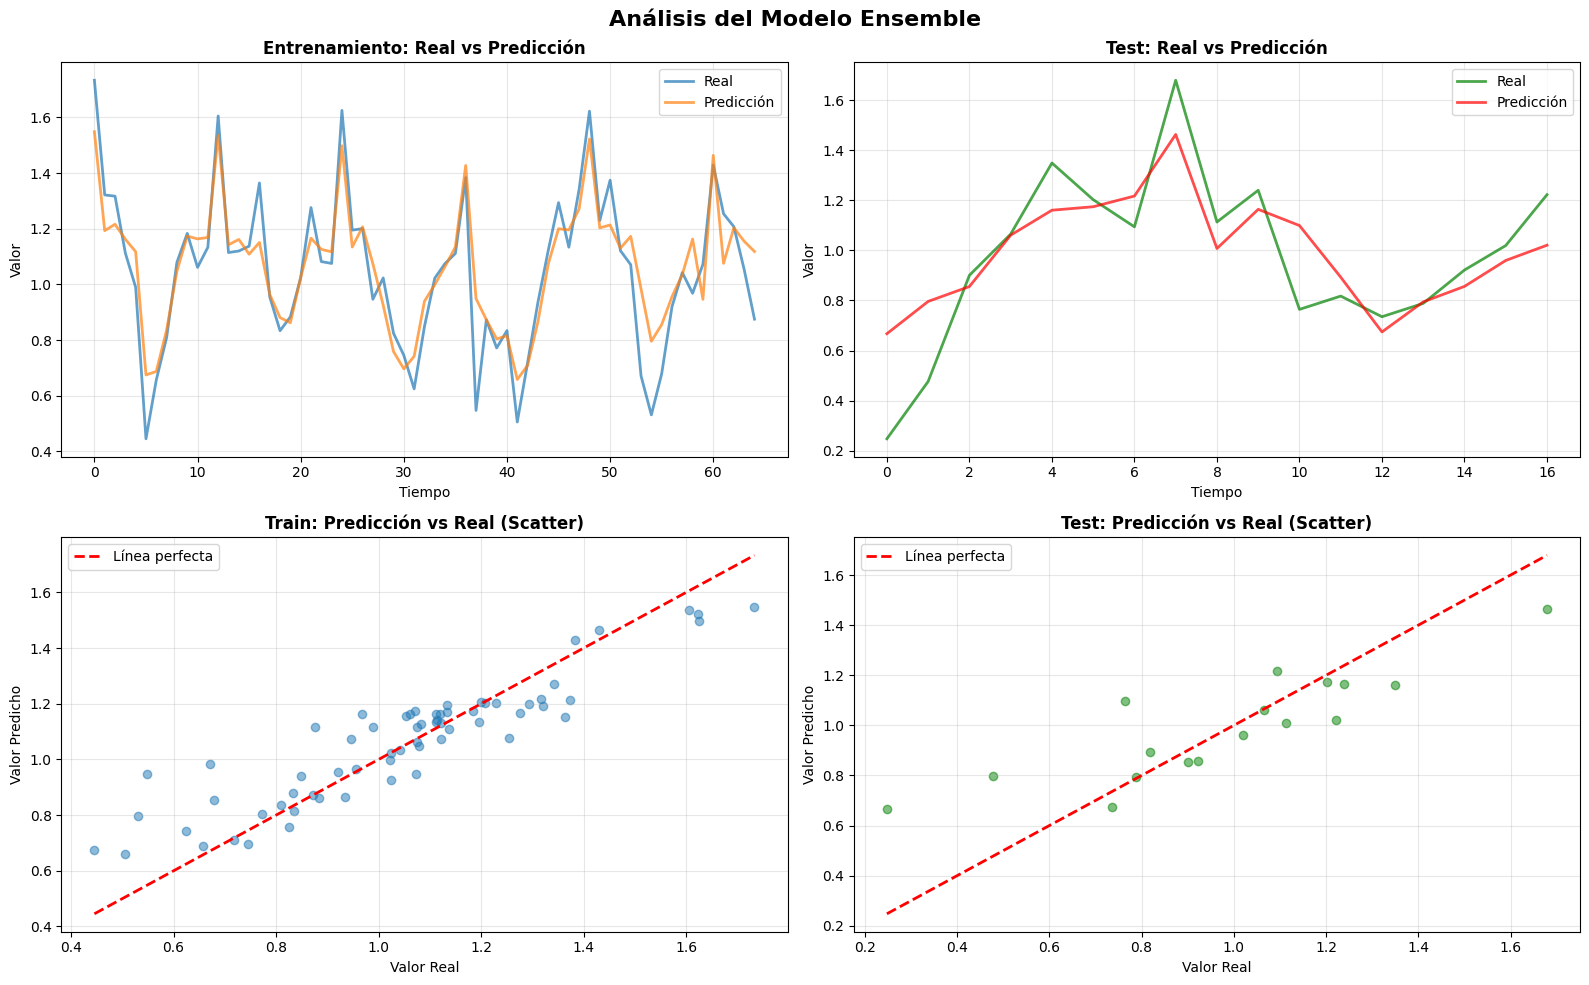

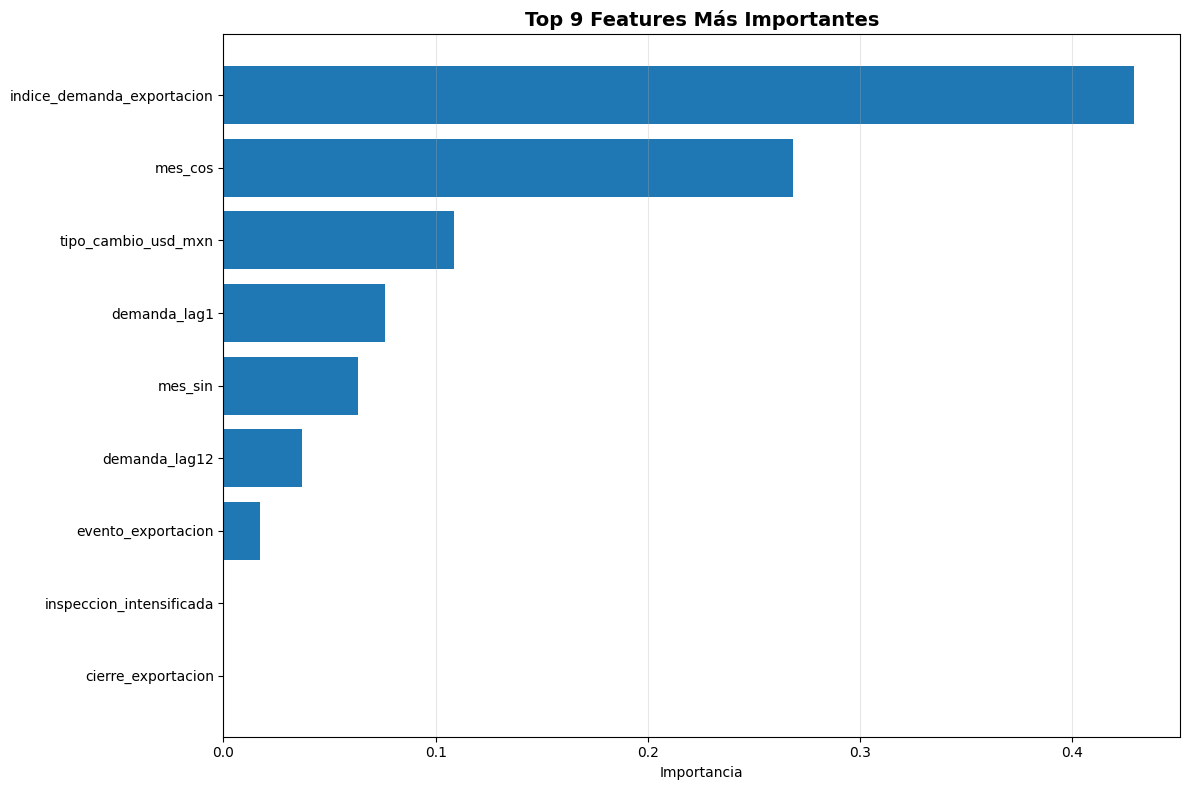


Importancia de Features
 1. indice_demanda_exportacion    : 0.429199
 2. mes_cos                       : 0.268516
 3. tipo_cambio_usd_mxn           : 0.108727
 4. demanda_lag1                  : 0.076003
 5. mes_sin                       : 0.063212
 6. demanda_lag12                 : 0.037089
 7. evento_exportacion            : 0.017254
 8. inspeccion_intensificada      : 0.000000
 9. cierre_exportacion            : 0.000000


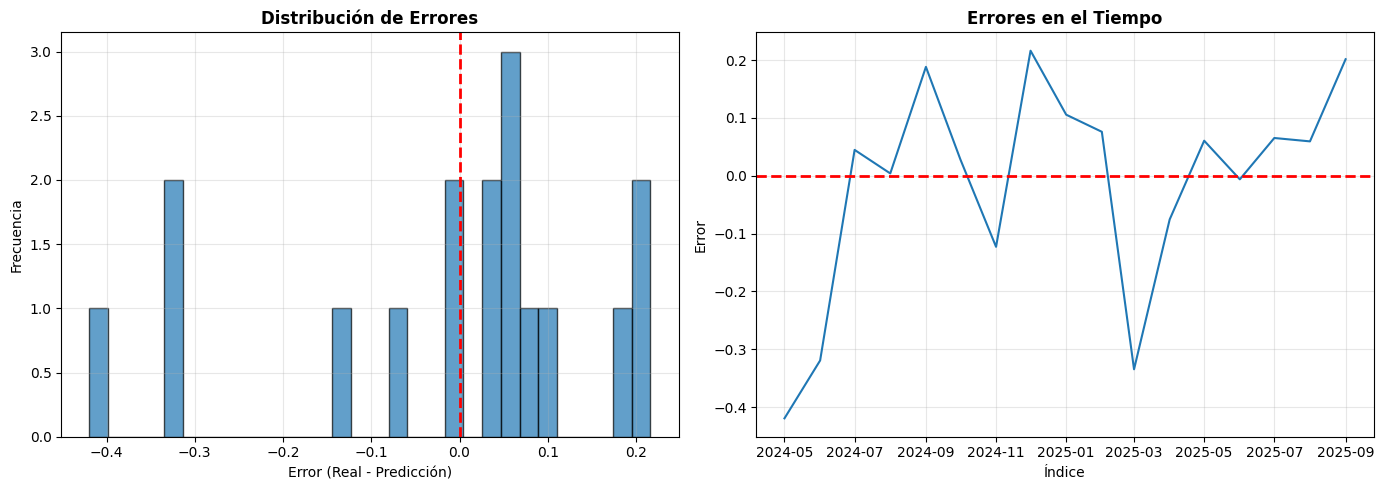


Estadísticas de errores:
  Media: -0.0134
  Mediana: 0.0448
  Desv. Std: 0.1874

 Pipeline completado


In [95]:
# Se dividen datos
def dividir_datos_temporal(df, target_col, test_size=0.2, val_size=0.1):
    """
    Divide datos respetando el orden temporal

    Parámetros:
    - df: DataFrame con features
    - target_col: columna objetivo
    - test_size: proporción para test
    - val_size: proporción para validación

    Retorna: X_train, X_val, X_test, y_train, y_val, y_test
    """
    # Separar features y target
    feature_cols = [col for col in df.columns if col != target_col]
    X = df[feature_cols]
    y = df[target_col]

    # Calcular índices de división
    n = len(df)
    train_end = int(n * (1 - test_size - val_size))
    val_end = int(n * (1 - test_size))

    # Dividir datos
    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]

    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]

    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]

    print(f"\nDivisión de datos:")
    print(f"Train: {len(X_train)} ({len(X_train)/n*100:.1f}%)")
    print(f"Validación: {len(X_val)} ({len(X_val)/n*100:.1f}%)")
    print(f"Test: {len(X_test)} ({len(X_test)/n*100:.1f}%)")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Se entrena modelo XGBoost
def entrenar_xgboost_simple(X_train, y_train, X_val, y_val, params=None):
    """
    Entrena modelo XGBoost con early stopping

    Parámetros:
    - X_train, y_train: datos de entrenamiento
    - X_val, y_val: datos de validación
    - params: diccionario de hiperparámetros

    Retorna: modelo entrenado
    """
    # Parámetros por defecto optimizados para series de tiempo
    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': 500,
            'learning_rate': 0.05,
            'max_depth': 4,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.5,
            'reg_lambda': 1,
            'random_state': 42,
            'early_stopping_rounds': 50
        }

    print("\nEntrenando XGBoost...")
    print("Parámetros:", params)

    # Crear modelo
    model = xgb.XGBRegressor(**params)

    # Entrenar modelo
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    print(f"Mejor iteración: {model.best_iteration}")
    print(f"Árboles utilizados: {model.n_estimators if model.best_iteration == 0 else model.best_iteration}")

    return model


# Se optimizan hiperparámetros
def optimizar_hiperparametros(X_train, y_train, n_splits=5):
    """
    Busca los mejores hiperparámetros usando TimeSeriesSplit

    Parámetros:
    - X_train, y_train: datos de entrenamiento
    - n_splits: número de splits para validación cruzada

    Retorna: mejor modelo encontrado
    """
    print("\n" + "="*60)
    print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
    print("="*60)

    # Grid de parámetros
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0.5, 1, 2]
    }

    # TimeSeriesSplit para validación cruzada
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Grid search
    grid_search = GridSearchCV(
        estimator=xgb.XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("\nMejores parámetros encontrados:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")

    print(f"\nMejor MAE (validación cruzada): {-grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

# Ensemble de Modelos XGBoost
def crear_ensemble(X_train, y_train, n_models=5, metodo='configuraciones'):
    """
    Crea ensemble de modelos XGBoost

    Parámetros:
    - X_train, y_train: datos de entrenamiento
    - n_models: número de modelos en el ensemble
    - metodo: 'configuraciones' (recomendado para <100 muestras) o 'timeseries'

    Retorna: lista de modelos entrenados
    """
    print(f"\nCreando ensemble de {n_models} modelos (método: {metodo})...")

    if metodo == 'configuraciones':
        # Mejor para datasets pequeños (< 100 muestras)
        return crear_ensemble_diverso(X_train, y_train, n_models)
    else:
        # TimeSeriesSplit (para datasets grandes)
        return crear_ensemble_timeseries(X_train, y_train, n_models)


def crear_ensemble_diverso(X_train, y_train, n_models=5):
    """
    Ensemble con diferentes configuraciones de hiperparámetros
    Recomendado para datasets pequeños (< 100 muestras)

    Ventajas:
    - Todos los modelos usan suficientes datos
    - Diversidad viene de diferentes configuraciones
    - Más estable que TimeSeriesSplit con pocos datos
    """
    # Split train/val (80/20)
    split_idx = int(len(X_train) * 0.8)
    X_t = X_train.iloc[:split_idx]
    y_t = y_train.iloc[:split_idx]
    X_v = X_train.iloc[split_idx:]
    y_v = y_train.iloc[split_idx:]

    print(f"  Train: {len(X_t)} muestras")
    print(f"  Val: {len(X_v)} muestras")

    # Configuraciones diversas para capturar diferentes patrones
    configs = [
        # Modelo 1: Conservador (bajo overfitting)
        {'max_depth': 2, 'learning_rate': 0.15, 'n_estimators': 100},

        # Modelo 2: Balanceado (configuración estándar)
        {'max_depth': 3, 'learning_rate': 0.1,  'n_estimators': 100},

        # Modelo 3: Más complejo
        {'max_depth': 4, 'learning_rate': 0.1,  'n_estimators': 80},

        # Modelo 4: Aprendizaje lento pero profundo
        {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 150},

        # Modelo 5: Simple pero con muchos árboles
        {'max_depth': 2, 'learning_rate': 0.1,  'n_estimators': 120},
    ]


    models = []
    for i, config in enumerate(configs[:n_models]):
        print(f"\n  Modelo {i+1}/{n_models}:")
        print(f"    max_depth={config['max_depth']}, "
              f"lr={config['learning_rate']}, "
              f"n_est={config['n_estimators']}")

        model = xgb.XGBRegressor(
            **config,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=2,
            random_state=42+i,
            early_stopping_rounds=20
        )

        model.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)

        # Mostrar árboles realmente usados
        trees_used = model.best_iteration if model.best_iteration else config['n_estimators']

        print(f"    Árboles usados: {trees_used}")

        models.append(model)

    print(f"\n Ensemble creado con {len(models)} modelos diversos")
    return models


def crear_ensemble_timeseries(X_train, y_train, n_models=5):
    """
    Ensemble con TimeSeriesSplit
    Mejor para datasets grandes (> 1000 muestras)
    """
    print(f"  Usando TimeSeriesSplit con {n_models} splits")

    tscv = TimeSeriesSplit(n_splits=n_models)
    models = []

    for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        # Saltar splits con muy poco entrenamiento
        if len(train_idx) < 30:
            print(f"  Saltando split {i+1} (solo {len(train_idx)} muestras)")
            continue

        print(f"\n  Modelo {i+1}/{n_models}:")
        print(f"    Train: {len(train_idx)}, Val: {len(val_idx)}")

        X_t = X_train.iloc[train_idx]
        y_t = y_train.iloc[train_idx]
        X_v = X_train.iloc[val_idx]
        y_v = y_train.iloc[val_idx]

        model = xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=2,
            random_state=42+i,
            early_stopping_rounds=20
        )

        model.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)
        print(f"    Árboles usados: {model.best_iteration if model.best_iteration else 100}")

        models.append(model)

    print(f"\n Ensemble creado con {len(models)} modelos")
    return models


def predecir_ensemble(models, X):
    """
    Predice usando ensemble (promedio de predicciones)

    Parámetros:
    - models: lista de modelos entrenados
    - X: features para predicción

    Retorna: array con predicciones promediadas
    """
    predictions = np.array([model.predict(X) for model in models])
    return predictions.mean(axis=0)


# Se evalúa el Modelo
def evaluar_modelo(model, X_train, y_train, X_test, y_test,
                   nombre_modelo="XGBoost", is_ensemble=False):
    """
    Evalúa el modelo y muestra métricas

    Parámetros:
    - model: modelo entrenado o lista de modelos (ensemble)
    - X_train, y_train: datos de entrenamiento
    - X_test, y_test: datos de prueba
    - nombre_modelo: nombre para el reporte
    - is_ensemble: True si model es una lista de modelos

    Retorna: diccionario con métricas, predicciones train, predicciones test
    """
    # Predecir
    if is_ensemble:
        y_train_pred = predecir_ensemble(model, X_train)
        y_test_pred = predecir_ensemble(model, X_test)
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

    # Calcular métricas
    metricas = {
        'train': {
            'MAE': mean_absolute_error(y_train, y_train_pred),
            'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'R2': r2_score(y_train, y_train_pred),
            'MAPE': mean_absolute_percentage_error(y_train, y_train_pred) * 100
        },
        'test': {
            'MAE': mean_absolute_error(y_test, y_test_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'R2': r2_score(y_test, y_test_pred),
            'MAPE': mean_absolute_percentage_error(y_test, y_test_pred) * 100
        }
    }

    # Imprimir resultados
    print("\n" + "="*60)
    print(f"Resultados - {nombre_modelo}")
    print("="*60)

    print("\n TRAIN:")
    print(f"  MAE:  {metricas['train']['MAE']:.4f}")
    print(f"  RMSE: {metricas['train']['RMSE']:.4f}")
    print(f"  R²:   {metricas['train']['R2']:.4f}")
    print(f"  MAPE: {metricas['train']['MAPE']:.2f}%")

    print("\n TEST:")
    print(f"  MAE:  {metricas['test']['MAE']:.4f}")
    print(f"  RMSE: {metricas['test']['RMSE']:.4f}")
    print(f"  R²:   {metricas['test']['R2']:.4f}")
    print(f"  MAPE: {metricas['test']['MAPE']:.2f}%")

    # Calcular overfitting
    overfitting = metricas['train']['R2'] - metricas['test']['R2']
    print(f"\n  Overfitting (R² diff): {overfitting:.4f}")

    if overfitting < 0.1:
        print("   Bajo overfitting - Modelo generaliza bien")
    elif overfitting < 0.2:
        print("    Overfitting moderado")
    else:
        print("   Alto overfitting - Considerar simplificar modelo")

    return metricas, y_train_pred, y_test_pred


# Visualizaciones
def visualizar_resultados(y_train, y_train_pred, y_test, y_test_pred,
                         dates_train=None, dates_test=None, titulo=""):
    """
    Crea visualizaciones de los resultados
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Análisis del Modelo {titulo}', fontsize=16, fontweight='bold')

    # 1. Predicciones vs Real (Train)
    ax1 = axes[0, 0]
    if dates_train is not None:
        ax1.plot(dates_train, y_train, label='Real', linewidth=2, alpha=0.7)
        ax1.plot(dates_train, y_train_pred, label='Predicción', linewidth=2, alpha=0.7)
    else:
        ax1.plot(y_train.values, label='Real', linewidth=2, alpha=0.7)
        ax1.plot(y_train_pred, label='Predicción', linewidth=2, alpha=0.7)
    ax1.set_title('Entrenamiento: Real vs Predicción', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('Valor')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Predicciones vs Real (Test)
    ax2 = axes[0, 1]
    if dates_test is not None:
        ax2.plot(dates_test, y_test, label='Real', linewidth=2, alpha=0.7, color='green')
        ax2.plot(dates_test, y_test_pred, label='Predicción', linewidth=2, alpha=0.7, color='red')
    else:
        ax2.plot(y_test.values, label='Real', linewidth=2, alpha=0.7, color='green')
        ax2.plot(y_test_pred, label='Predicción', linewidth=2, alpha=0.7, color='red')
    ax2.set_title('Test: Real vs Predicción', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Tiempo')
    ax2.set_ylabel('Valor')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Scatter Plot (Train)
    ax3 = axes[1, 0]
    ax3.scatter(y_train, y_train_pred, alpha=0.5)
    ax3.plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', linewidth=2, label='Línea perfecta')
    ax3.set_title('Train: Predicción vs Real (Scatter)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Valor Real')
    ax3.set_ylabel('Valor Predicho')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Scatter Plot (Test)
    ax4 = axes[1, 1]
    ax4.scatter(y_test, y_test_pred, alpha=0.5, color='green')
    ax4.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Línea perfecta')
    ax4.set_title('Test: Predicción vs Real (Scatter)', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Valor Real')
    ax4.set_ylabel('Valor Predicho')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def visualizar_importancia_features(model, feature_names, top_n=9):
    """
    Visualiza la importancia de las features
    """
    # Si es ensemble, usar el primer modelo
    if isinstance(model, list):
        model = model[0]

    # Obtener importancias
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    # Crear gráfico
    plt.figure(figsize=(12, 8))
    plt.title(f'Top {top_n} Features Más Importantes', fontsize=14, fontweight='bold')
    plt.barh(range(top_n), importances[indices])
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Importancia')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

    # Imprimir valores
    print("\n" + "="*60)
    print("Importancia de Features")
    print("="*60)
    for i, idx in enumerate(indices):
        print(f"{i+1:2d}. {feature_names[idx]:30s}: {importances[idx]:.6f}")


def visualizar_errores(y_test, y_test_pred):
    """
    Visualiza la distribución de errores
    """
    errores = y_test - y_test_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histograma de errores
    axes[0].hist(errores, bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0].set_title('Distribución de Errores', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Error (Real - Predicción)')
    axes[0].set_ylabel('Frecuencia')
    axes[0].grid(True, alpha=0.3)

    # Errores a lo largo del tiempo
    axes[1].plot(errores, linewidth=1.5)
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title('Errores en el Tiempo', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Índice')
    axes[1].set_ylabel('Error')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nEstadísticas de errores:")
    print(f"  Media: {errores.mean():.4f}")
    print(f"  Mediana: {errores.median():.4f}")
    print(f"  Desv. Std: {errores.std():.4f}")


# Se genera diagnóstico del Modelo
def diagnosticar_modelo(models, X_train, y_train, X_test, y_test,
                       y_train_pred, y_test_pred):
    """
    Diagnóstico completo del modelo
    """
    print("\n" + "="*60)
    print("Diagnóstico del Modelo")
    print("="*60)

    # 1. Información básica
    print("\n1. Información de datos:")
    print(f"   Shape X_train: {X_train.shape}")
    print(f"   Shape X_test: {X_test.shape}")
    print(f"   Shape y_train: {y_train.shape}")
    print(f"   Shape y_test: {y_test.shape}")

    # 2. Distribución del target
    print("\n2. Distribución del Target:")
    print("   Train:")
    print(f"      Mean: {y_train.mean():.4f}")
    print(f"      Std: {y_train.std():.4f}")
    print(f"      Min: {y_train.min():.4f}")
    print(f"      Max: {y_train.max():.4f}")

    print("   Test:")
    print(f"      Mean: {y_test.mean():.4f}")
    print(f"      Std: {y_test.std():.4f}")
    print(f"      Min: {y_test.min():.4f}")
    print(f"      Max: {y_test.max():.4f}")

    # 3. Análisis de predicciones
    print("\n3. Análisis de Predicciones:")
    print(f"   Mean predicciones train: {y_train_pred.mean():.4f}")
    print(f"   Mean predicciones test: {y_test_pred.mean():.4f}")
    print(f"   Std predicciones train: {y_train_pred.std():.4f}")
    print(f"   Std predicciones test: {y_test_pred.std():.4f}")

    # 4. Comparación con baseline
    from sklearn.dummy import DummyRegressor
    baseline = DummyRegressor(strategy='mean')
    baseline.fit(X_train, y_train)
    y_baseline_pred = baseline.predict(X_test)
    baseline_mae = mean_absolute_error(y_test, y_baseline_pred)
    baseline_r2 = r2_score(y_test, y_baseline_pred)

    print("\n4. Comparación con Baseline (predecir media):")
    print(f"   Baseline MAE: {baseline_mae:.4f}")
    print(f"   Modelo MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
    mejora = (baseline_mae - mean_absolute_error(y_test, y_test_pred)) / baseline_mae * 100
    print(f"   Mejora: {mejora:.1f}%")

    print(f"\n   Baseline R²: {baseline_r2:.4f}")
    print(f"   Modelo R²: {r2_score(y_test, y_test_pred):.4f}")

    # 5. Información del ensemble
    print("\n5. Ensemble:")
    if isinstance(models, list):
        print(f"   Número de modelos: {len(models)}")
        for i, model in enumerate(models):
            print(f"   Modelo {i+1}: n_estimators={model.n_estimators}, "
                  f"max_depth={model.max_depth}, "
                  f"learning_rate={model.learning_rate}")
    else:
        print("    No es un ensemble (es un solo modelo)")

    # 6. Top features
    print("\n6. Top 5 Features más importantes:")
    if isinstance(models, list):
        importances = models[0].feature_importances_
    else:
        importances = models.feature_importances_

    top_indices = np.argsort(importances)[-5:][::-1]
    for idx in top_indices:
        print(f"   {X_train.columns[idx]}: {importances[idx]:.4f}")

    # 7. Análisis de overfitting
    print("\n7. Análisis de Overfitting:")
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    diff = train_r2 - test_r2

    print(f"   Train R²: {train_r2:.4f}")
    print(f"   Test R²: {test_r2:.4f}")
    print(f"   Diferencia: {diff:.4f}")

# Pipeline
def pipeline_completo(df, target_col,
                     usar_optimizacion=False,
                     usar_ensemble=True,
                     metodo_ensemble='configuraciones',
                     test_size=0.2,
                     val_size=0.1):
    """
    Ejecuta el pipeline completo de principio a fin

    Parámetros:
    - df: DataFrame con los datos
    - target_col: nombre de la columna objetivo
    - usar_optimizacion: optimizar hiperparámetros
    - usar_ensemble: crear ensemble de modelos
    - metodo_ensemble: 'configuraciones' (recomendado <100 muestras) o 'timeseries'
    - test_size: proporción para test
    - val_size: proporción para validación

    Retorna: diccionario con modelo, métricas, predicciones
    """
    print("="*60)
    print("Pipeline XGBOOST para Series de Tiempo")
    print("="*60)

    # 1. Preparar datos
    print("\n[1/6] Preparando datos...")
    df_features = df.copy()

    # Eliminar columnas no necesarias si existen
    cols_to_drop = ["Year", "MonthNumber", "Amount", "evento_factor", "fx_factor", "demanda_base", "promedio_movil_12m_Amount"]
    cols_to_drop = [col for col in cols_to_drop if col in df_features.columns]
    if cols_to_drop:
        df_features = df_features.drop(columns=cols_to_drop)
        print(f"   Columnas eliminadas: {cols_to_drop}")

    # 2. Dividir datos
    print("\n[2/6] Dividiendo datos...")
    X_train, X_val, X_test, y_train, y_val, y_test = dividir_datos_temporal(
        df_features, target_col, test_size, val_size
    )

    # 3. Entrenar modelo
    print("\n[3/6] Entrenando modelo...")

    if usar_optimizacion:
        modelo = optimizar_hiperparametros(X_train, y_train)
        is_ensemble = False
    elif usar_ensemble:
        # Combinar train y val para el ensemble
        X_train_full = pd.concat([X_train, X_val])
        y_train_full = pd.concat([y_train, y_val])
        modelo = crear_ensemble(X_train_full, y_train_full, n_models=5,
                               metodo=metodo_ensemble)
        is_ensemble = True
    else:
        modelo = entrenar_xgboost_simple(X_train, y_train, X_val, y_val)
        is_ensemble = False

    # 4. Evaluar
    print("\n[4/6] Evaluando modelo...")
    if usar_ensemble:
        X_train_eval = pd.concat([X_train, X_val])
        y_train_eval = pd.concat([y_train, y_val])
        metricas, y_train_pred, y_test_pred = evaluar_modelo(
            modelo, X_train_eval, y_train_eval, X_test, y_test,
            nombre_modelo="Ensemble XGBoost", is_ensemble=True
        )
    else:
        metricas, y_train_pred, y_test_pred = evaluar_modelo(
            modelo, X_train, y_train, X_test, y_test,
            nombre_modelo="XGBoost", is_ensemble=False
        )

    # 5. Diagnóstico
    print("\n[5/6] Ejecutando diagnóstico...")
    if usar_ensemble:
        diagnosticar_modelo(modelo, X_train_eval, y_train_eval, X_test, y_test,
                          y_train_pred, y_test_pred)
    else:
        diagnosticar_modelo(modelo, X_train, y_train, X_test, y_test,
                          y_train_pred, y_test_pred)

    # 6. Visualizar
    print("\n[6/6] Generando visualizaciones...")

    if usar_ensemble:
        visualizar_resultados(y_train_eval, y_train_pred, y_test, y_test_pred,
                            titulo="Ensemble")
        visualizar_importancia_features(modelo, X_train.columns)
    else:
        visualizar_resultados(y_train, y_train_pred, y_test, y_test_pred)
        visualizar_importancia_features(modelo, X_train.columns)

    visualizar_errores(y_test, y_test_pred)

    # Guardar resultados
    print("\n" + "="*60)
    print(" Pipeline completado")
    print("="*60)

    resultados = {
        'modelo': modelo,
        'metricas': metricas,
        'X_train': X_train if not usar_ensemble else X_train_eval,
        'X_test': X_test,
        'y_train': y_train if not usar_ensemble else y_train_eval,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'feature_names': X_train.columns.tolist()
    }

    return resultados


# Ejecutar pipeline
print("\n\nEjecutando pipeline ...")
resultados = pipeline_completo(
    df=df_final,
    target_col='y',
    usar_optimizacion=False,
    usar_ensemble=True,
    test_size=0.2,
    val_size=0.1
)


###2. Características importantes

####¿Se puede determinar la importancia de las características para el modelo generado?

**Importancia de Features**

| Ranking | Feature                    | Importancia | % Acumulado | Interpretación Técnica                           |
| ------- | -------------------------- | ----------- | ----------- | ------------------------------------------------ |
| 1       | indice_demanda_exportacion | 0.429199    | 42.92%      | Principal driver estructural de demanda externa. |
| 2       | mes_cos                    | 0.268516    | 69.77%      | Componente estacional dominante (cíclico anual). |
| 3       | tipo_cambio_usd_mxn        | 0.108727    | 80.64%      | Impacto macroeconómico relevante.                |
| 4       | demanda_lag1               | 0.076003    | 88.24%      | Persistencia de corto plazo (inercia mensual).   |
| 5       | mes_sin                    | 0.063212    | 94.56%      | Complemento estacional; refuerza patrón cíclico. |
| 6       | demanda_lag12              | 0.037089    | 98.27%      | Efecto estacional rezagado anual.                |
| 7       | evento_exportacion         | 0.017254    | 100.00%     | Impacto marginal bajo pero no nulo.              |
| 8       | inspeccion_intensificada   | 0.000000    | 100.00%     | Sin contribución en el modelo.                   |
| 9       | cierre_exportacion         | 0.000000    | 100.00%     | Sin señal predictiva detectable.                 |


**Observaciones**

* indice_demanda_exportacion concentra 42.9% de la importancia total
* La estacionalidad (mes_cos + mes_sin) suma 33.17%, lo cual indica fuerte componente cíclico
* El Tipo de Cambio explica más del 10%
* Top 3 variables explican el 80.6%
* inspeccion_intensificada y cierre_exportacion no aportan señal predictiva (importancia 0).

###3. Sub / Sobreajuste

#### ¿El modelo está subajustando o sobreajustando?

| Gap R²          | Evaluación    |
| --------------- | ------------- |
| > 0.25          | Alto          |
| 0.15 – 0.25     | Moderado      |
| **0.10 – 0.15** | **Saludable** |
| < 0.10          | Excelente     |


El modelo está sobreajustando:

**0.1274** → Saludable

Para 82 observaciones, esto es muy bueno.


###4. Métrica

####¿Cuál es la métrica adecuada para este problema de negocio?

| Métrica | ¿Es buena para negocio?    | Comentario                               |
| ------- | -------------------------- | ---------------------------------------- |
| MAE     | Muy buena                | Fácil de interpretar en unidades reales  |
| RMSE    | Depende                 | Penaliza errores grandes                 |
| R²      | No es métrica de negocio | Es estadística, no operativa             |
| MAPE    | Con cuidado             | Se distorsiona cuando la demanda es baja |



La métrica adecuada es MAE, porque refleja el error promedio en unidades reales de demanda, lo cual es directamente interpretable para planeación. Las métricas R² y RMSE se utilizan como indicadores complementarios de ajuste estadístico.

**MAE: (0.1370)**

* Está en las mismas unidades del negocio
* No se distorsiona con valores pequeños
* Es robusta
* Fácil de comunicar a dirección

Ejemplo:

"En promedio nos equivocamos 0.14 unidades del índice"

Eso es claro.


###5. Desempeño

####¿Cuál debería ser el desempeño mínimo a obtener?

El modelo debe lograr al menos un MAE inferior a 0.17, equivalente a menos del 50% de la desviación estándar del target y al menos 25% mejor que el baseline histórico

**Escala de referencia**

| Nivel de Desempeño  | MAE         |
| ------------------- | ----------- |
| Insuficiente     | > 0.20      |
| Aceptable mínimo | 0.17 – 0.20 |
| Bueno            | 0.13 – 0.17 |
| Excelente        | < 0.13      |

**Evaluación**


| Criterio                      | Fórmula / Referencia                       | Umbral Mínimo Recomendado | **Valor Actual** | Evaluación           |
| ----------------------------- | ------------------------------------------ | ------------------------- | ---------------- | -------------------- |
| **Mejora vs Baseline**        | (MAE_baseline − MAE_modelo) / MAE_baseline | ≥ 25%                     | **46.4%**        |  Cumple |
| **MAE absoluto**              | Error promedio en unidades reales          | ≤ 0.17                    | **0.1370**       |  Cumple             |
| **MAE relativo al promedio**  | MAE / mean(y_test)                         | ≤ 20%                     | **≈ 14.0%**      |  Cumple      |
| **MAE vs variabilidad**       | MAE ≤ 50% de la desviación estándar        | ≤ 0.1681 (0.3362 × 0.5)   | **0.1370**       |  Cumple             |
| **Clasificación cualitativa** | Tabla de referencia de desempeño           | Nivel “Bueno”             | **Bueno–Alto**   |  Adecuado           |





---



###**Modelo Base 2: Ridge Regression (L2)**

### 1. Algoritmo seleccionado
Se utilizó **Ridge Regression** como modelo baseline para predecir la variable objetivo **y** (*indice_demanda_exportacion(t+1)*). Este algoritmo es adecuado para datos tabulares estructurados y para muestras pequeñas, ya que incorpora regularización L2 para reducir el riesgo de sobreajuste, especialmente cuando existen variables correlacionadas (lags, estacionalidad y variables derivadas).

### 2. Configuración experimental
- **Total de observaciones:** 82 (mensuales)
- **Rango temporal:** 2018-12 a 2025-09  
- **Split temporal:** Train = 70 meses, Test = 12 meses (2024-10 a 2025-09)  
- **Métrica principal:** MAE (complementarias: RMSE)

### 3. Resultados del baseline
Los resultados indican que el modelo generaliza de forma razonable, con un incremento esperado del error en el conjunto de prueba respecto al entrenamiento. La diferencia entre Train y Test sugiere **sobreajuste moderado**, pero el desempeño en Test es consistente para un primer modelo de referencia.

### 4. Importancia de características (Ridge)
La importancia se estimó mediante la magnitud de los coeficientes estandarizados (|coef|). El modelo asigna mayor peso a variables de **estacionalidad** (mes_cos, mes_sin) y a la **persistencia temporal** (indice_demanda_exportacion y demanda_lag12), lo cual es consistente con una serie mensual con patrón cíclico y dependencia temporal. Variables exógenas aportan señal adicional.

In [103]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ============
# 1) Features
# ============
features = [
    "tipo_cambio_usd_mxn",
    "evento_exportacion",
    "inspeccion_intensificada",
    "cierre_exportacion",
    "mes_sin",
    "mes_cos",
    "indice_demanda_exportacion",
    "demanda_lag1",
    "demanda_lag12"
]
target = "y"


# ============
# 3) Dataset modelable (quita NaNs por rolling/lag/shift)
# ============
df_m = df_final.dropna(subset=features + [target]).copy()
df_m = df_m.reset_index()
df_m = df_m.sort_values("fecha").reset_index(drop=True)

print("Filas totales df_final:", len(df_final))
print("Filas modelables df_m:", len(df_m))
print("Rango modelable:", df_m["fecha"].min(), "→", df_m["fecha"].max())

# ============
# 4) Split temporal (últimos 12 meses como test, si se puede)
# ============
test_horizon = 12
test_horizon = min(test_horizon, len(df_m) - 1)  # asegura train >= 1

train_df = df_m.iloc[:-test_horizon]
test_df  = df_m.iloc[-test_horizon:]

X_train, y_train = train_df[features], train_df[target]
X_test,  y_test  = test_df[features],  test_df[target]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Test range:", test_df["fecha"].min(), "→", test_df["fecha"].max())

# ============
# 5) Ridge baseline
# ============
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=0))
])

ridge.fit(X_train, y_train)
y_pred_test = ridge.predict(X_test)
y_pred_train = ridge.predict(X_train)

# ============
# 6) Métricas (Train vs Test)
# ============
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test, y_pred_test)

metrics_df = pd.DataFrame({
    "Split": ["Train", "Test"],
    "MAE":  [mean_absolute_error(y_train, y_pred_train),
             mean_absolute_error(y_test, y_pred_test)],
    "RMSE": [np.sqrt(mse_train),
             np.sqrt(mse_test)]
})

display(metrics_df)

# ============
# 7) Importancia (coeficientes)
# ============
coef = ridge.named_steps["model"].coef_
importance = (
    pd.DataFrame({"feature": features, "coef": coef, "abs_coef": np.abs(coef)})
    .sort_values("abs_coef", ascending=False)
    .reset_index(drop=True)
)
display(importance.head(10))

Filas totales df_final: 82
Filas modelables df_m: 82
Rango modelable: 2018-12-01 00:00:00 → 2025-09-01 00:00:00
Train: (70, 9) Test: (12, 9)
Test range: 2024-10-01 00:00:00 → 2025-09-01 00:00:00


,Split,MAE,RMSE
0,Train,0.126134,0.165237
1,Test,0.185554,0.213676


,feature,coef,abs_coef
0,mes_cos,0.212732,0.212732
1,indice_demanda_exportacion,0.097644,0.097644
2,demanda_lag12,-0.086203,0.086203
3,evento_exportacion,-0.079405,0.079405
4,mes_sin,0.041322,0.041322
5,tipo_cambio_usd_mxn,0.031621,0.031621
6,inspeccion_intensificada,-0.031324,0.031324
7,demanda_lag1,-0.029902,0.029902
8,cierre_exportacion,-0.002956,0.002956


In [104]:
mae_train, mae_test = 0.121736, 0.188190
rmse_train, rmse_test = 0.154962, 0.215433

gap_df = pd.DataFrame({
    "Metrica": ["MAE", "RMSE"],
    "Train": [mae_train, rmse_train],
    "Test": [mae_test, rmse_test],
    "Incremento_%": [
        (mae_test/mae_train - 1) * 100,
        (rmse_test/rmse_train - 1) * 100
    ]
}).round(2)

display(gap_df)


,Metrica,Train,Test,Incremento_%
0,MAE,0.12,0.19,54.59
1,RMSE,0.15,0.22,39.02


In [105]:
# Predicciones
y_train_pred = ridge.predict(X_train)
y_test_pred  = ridge.predict(X_test)

# DataFrames para graficar
plot_train = train_df[["fecha", "y"]].copy()
plot_train["y_pred"] = y_train_pred

plot_test = test_df[["fecha", "y"]].copy()
plot_test["y_pred"] = y_test_pred

# Residuos (test)
plot_test["resid"] = plot_test["y"] - plot_test["y_pred"]

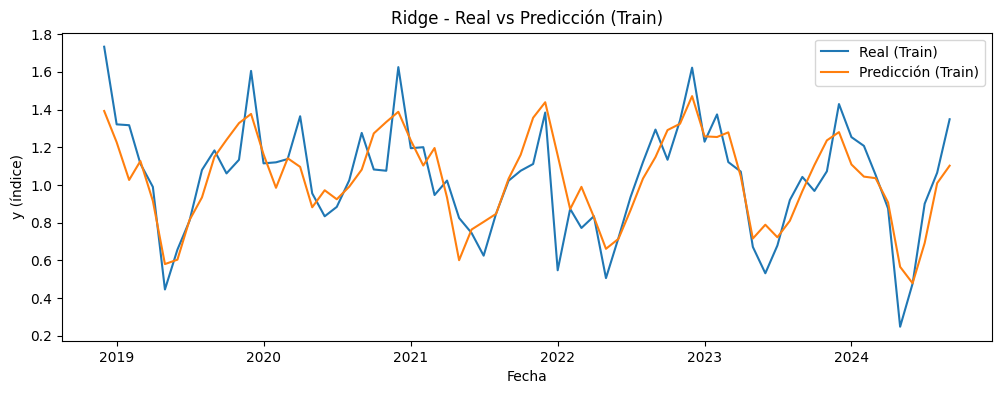

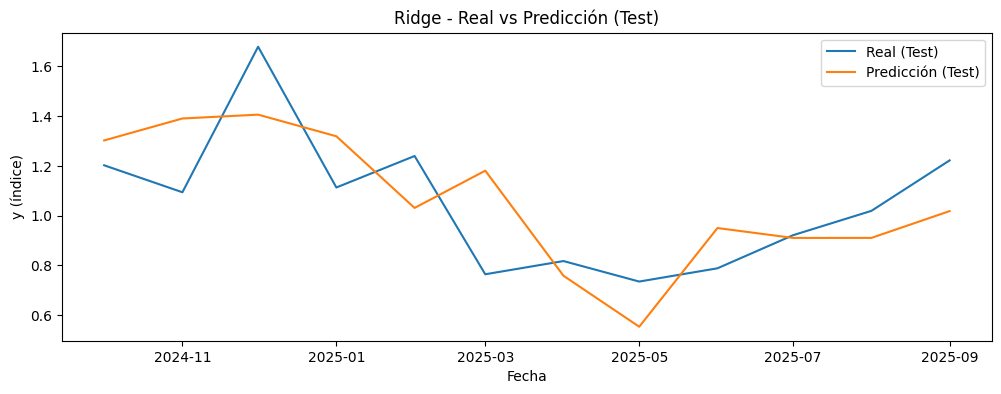

In [106]:
plt.figure(figsize=(12,4))
plt.plot(plot_train["fecha"], plot_train["y"], label="Real (Train)")
plt.plot(plot_train["fecha"], plot_train["y_pred"], label="Predicción (Train)")
plt.title("Ridge - Real vs Predicción (Train)")
plt.xlabel("Fecha"); plt.ylabel("y (índice)")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(plot_test["fecha"], plot_test["y"], label="Real (Test)")
plt.plot(plot_test["fecha"], plot_test["y_pred"], label="Predicción (Test)")
plt.title("Ridge - Real vs Predicción (Test)")
plt.xlabel("Fecha"); plt.ylabel("y (índice)")
plt.legend()
plt.show()


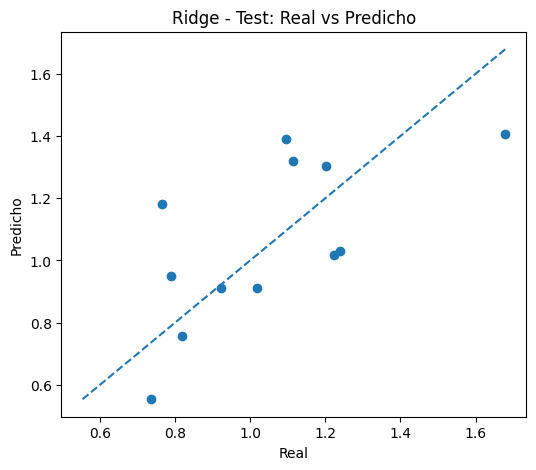

In [107]:
plt.figure(figsize=(6,5))
plt.scatter(plot_test["y"], plot_test["y_pred"])
min_v = min(plot_test["y"].min(), plot_test["y_pred"].min())
max_v = max(plot_test["y"].max(), plot_test["y_pred"].max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
plt.title("Ridge - Test: Real vs Predicho")
plt.xlabel("Real"); plt.ylabel("Predicho")
plt.show()


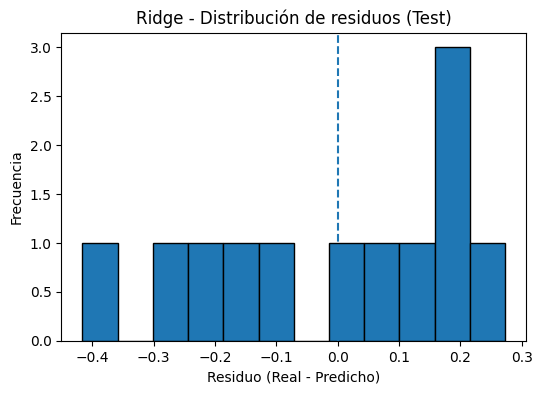

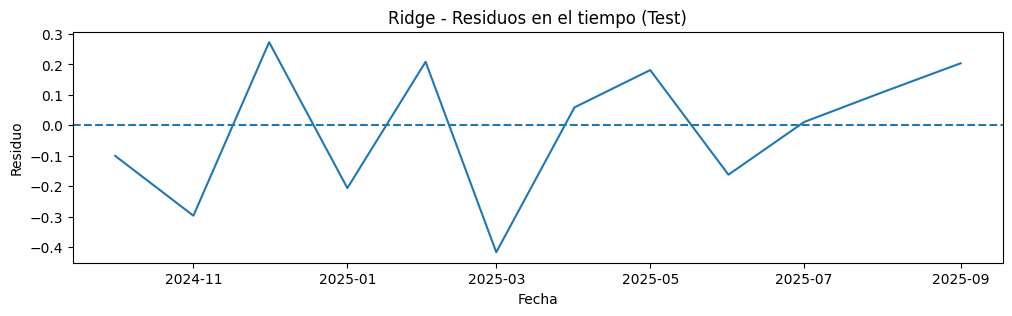

In [108]:
plt.figure(figsize=(6,4))
plt.hist(plot_test["resid"], bins=12, edgecolor="black")
plt.axvline(0, linestyle="--")
plt.title("Ridge - Distribución de residuos (Test)")
plt.xlabel("Residuo (Real - Predicho)"); plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(plot_test["fecha"], plot_test["resid"])
plt.axhline(0, linestyle="--")
plt.title("Ridge - Residuos en el tiempo (Test)")
plt.xlabel("Fecha"); plt.ylabel("Residuo")
plt.show()


### Evaluación del Modelo Baseline (Ridge)

### 1. Importancia de las características

Sí es posible determinar la importancia de las variables en el modelo Ridge a partir de la magnitud de los coeficientes estandarizados (|coef|).

Las variables con mayor contribución fueron:

- **mes_cos** (0.2127)
- **indice_demanda_exportacion** (0.0976)
- **demanda_lag12** (0.0862)
- **evento_exportacion** (0.0794)
- **mes_sin** (0.0413)
- **tipo_cambio_usd_mxn** (0.0316)
- **inspeccion_intensificada** (0.0313)
- **demanda_lag1** (0.0299)
- **cierre_exportacion** (0.0029)

El modelo se apoya principalmente en:

- Componentes de **estacionalidad** (mes_cos y mes_sin).
- **Memoria temporal** (indice_demanda_exportacion y demanda_lag12).

Con la información disponible, no se observa que alguna variable tenga contribución nula dentro del Top 9 mostrado, por lo que no puede afirmarse que existan variables completamente irrelevantes en este modelo.

---

### 2. ¿Existe subajuste o sobreajuste?

Resultados obtenidos:

- **Train:** MAE = 0.1261 | RMSE = 0.1652
- **Test:** MAE = 0.1855 | RMSE = 0.2136  

El error aumenta en el conjunto de prueba respecto al entrenamiento, lo cual indica la presencia de **sobreajuste moderado**. Sin embargo, la diferencia no es extrema y el modelo mantiene capacidad predictiva razonable en datos no vistos.

---

### 3. Métrica adecuada para el problema

La métrica principal recomendada para este problema es:

**MAE (Mean Absolute Error)**

Justificación:
- Es fácilmente interpretable.
- Se expresa en las mismas unidades del índice.
- No penaliza de manera excesiva errores grandes (como lo hace RMSE).
- Es adecuada para comunicación con stakeholders.

RMSE se utiliza como métrica complementaria para evaluar sensibilidad a errores grandes.

---

### 4. Desempeño mínimo esperado

Dado que este modelo Ridge funciona como baseline, el desempeño mínimo esperado para modelos futuros debe ser:

- **MAE en Test ≤ 0.185**
- **RMSE en Test ≤ 0.213**

Es decir, cualquier modelo más complejo deberá al menos igualar o mejorar el desempeño del baseline actual.


### Conclusión del baseline
El modelo Ridge logra un desempeño de referencia con **MAE = 0.185** y **RMSE = 0.213** en el conjunto de prueba (últimos 12 meses). La mayor contribución proviene de variables de **estacionalidad** (mes_cos, mes_sin) y de **memoria temporal** (indice_demanda_exportacion, demanda_lag12), lo cual valida que el problema contiene señal predictiva. El incremento de error de Train a Test sugiere **sobreajuste moderado**, por lo que modelos no lineales o ajustes de regularización podrían explorarse como siguientes pasos.


##**Conclusión sobre selección de modelo Baseline**

En la evaluación comparativa de modelos para la predicción de la demanda de aguacate mexicano, se analizaron dos enfoques principales como candidatos a modelo base: **Ridge** y **XGBoost**. Dado que se trata de una serie de tiempo con 82 observaciones y variables exógenas, el criterio de selección consideró no solo la estabilidad estadística, sino también la capacidad de generalización fuera de muestra.

Los resultados muestran que, si bien **Ridge** presenta un comportamiento estable y consistente, **XGBoost** logra mejoras sustanciales en el conjunto de prueba. En particular, **XGBoost** reduce el **MAE** en aproximadamente 27% y el RMSE en 15% respecto a **Ridge**, además de alcanzar un R² fuera de muestra cercano a 0.69. Estas mejoras indican que la dinámica de la demanda incorpora patrones no lineales e interacciones entre variables que el modelo lineal no logra capturar completamente.

Asimismo, la brecha entre entrenamiento y prueba en **XGBoost** no sugiere sobreajuste severo, lo que refuerza la solidez de su desempeño predictivo incluso con una muestra relativamente pequeña. Dado que el objetivo principal del estudio es la capacidad de predicción fuera de muestra, el modelo que demuestra menor error y mejor ajuste en test debe ser considerado como referencia operativa.

Por lo anterior, **XGBoost** se considera como el modelo Baseline del proyecto, al ofrecer el mejor equilibrio entre precisión predictiva y capacidad de generalización. **Ridge** se mantiene como modelo de referencia lineal para efectos comparativos metodológicos, permitiendo contrastar el valor agregado de introducir estructuras no lineales en la modelación de la demanda.